In [8]:
# Construction de la base B0  à partir de laquelle je vais gérer les datasets d'apprentissage.

# Rappel dataset : (inputs), (targets), (aux), (compa)
# inputs: lien AB, lien BA
# targets : antilope 72 h / 5min + antilope 1 h / 60 min
# aux : precip A? B, qualité antilope, hydre
# compa: PNP, estimation dominique

# Etape 2 construction des targets / aux
# -> on range les targets et les aux dans les rép
# -> on créée un dictionnaire lien[timestamp] = {stats_rain : [ratio_p_sup0, ratio_p_1mm, ratio_p_3_mm, ratio_p_6mm, max],
#                                                       stats_hail : nb classe avec grêle"], 
                                                     # stats_snow : nb classe neige]

In [33]:
from os.path import join, isdir, isfile
from os import listdir as ls
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time 
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
import sys
sys.path.append('/home/mdso/lepetitp/ppc/WEBCAMS/src/raincell')
# ! pip install bokeh
from ia.learning.dependencies.transformations import TimeSeriesTransform
from ia.learning.dependencies.datasets import VizDataset, TestDataset, custom_collate_fn
from torch.utils.data import DataLoader, WeightedRandomSampler, SequentialSampler

from ia.learning.dependencies.architectures import load_archi
from ia.learning.dependencies.cost_functions import CombinedLoss, compute_metrics, compute_confusion_matrix
import torch.optim as optim
from ia.learning.dependencies.scores import calculate_metrics, trailing_moving_average


In [34]:
# dictionnaire de l'ensemble des indices de CMLs:
with open('/scratch/mdso/lepetitp/ppc/RAINCELL/METADATA/dict_indices_290424.pickle', 'rb') as file:
    dict_links = pickle.load(file)

In [35]:
# Directories
dir_database = '/scratch/mdso/lepetitp/ppc/RAINCELL/datasets/database_debiasing'
dir_datasets = '/scratch/mdso/lepetitp/ppc/RAINCELL/datasets/debiasing_20240814'
dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240814"
dir_old_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240430"

In [37]:
# Define a dataset that yields a month of data for a given id
from torch.utils.data import Dataset
from ia.learning.dependencies.datasets import TrainingDataset, custom_collate_fn
from ia.learning.dependencies.transformations import TimeSeriesTransform
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix    
from datetime import datetime, timedelta

class TestDataset_5min(Dataset):
    def __init__(self, root_dir, dict_links, list_linkid_month, transform):
        """
        Args:
            root_dir (str): Directory with all the training/validation/test data.
            dict_indices (dict): Nested dictionary as described.
            mode (str): One of 'train', 'val_inter', 'val_intra', 'test_inter', 'test_intra'.
        """
        self.root_dir = root_dir
        self.dict_links = dict_links
        self.list_linkid_month = list_linkid_month
        self.links = sorted(set([linkid[0] for linkid in list_linkid_month]))
        self.timestamps = {linkid:{} for linkid in self.links}
        self.transform = transform

        # Build the samples list and their weights
        for linkid_month in self.list_linkid_month:
            linkid = linkid_month[0]
            month = linkid_month[1]
            if month not in self.timestamps[linkid]:
                self.timestamps[linkid][month] = {'timestamps':[]}
            for timestamp in sorted(ls(join(root_dir, str(linkid), month))):
                self.timestamps[linkid][month]['timestamps'].append(timestamp)

        # sort the timestamps to ensure contiguity
        for (linkid, month) in self.list_linkid_month:
            self.timestamps[linkid][month]['timestamps'] = sorted(self.timestamps[linkid][month]['timestamps'])
    
                
        print("nb of samples in :", len(self.list_linkid_month))

    def __len__(self):
        return len(self.list_linkid_month)

    def __getitem__(self, idx):
        linkid, month = self.list_linkid_month[idx]
        # print(self.list_linkid_month[idx])

        
        for k, timestamp in enumerate(self.timestamps[linkid][month]['timestamps']):
            # print(timestamp)
            inputs_file = f'{linkid}_{timestamp}_attenuations.pt'
            targets_file = f'{linkid}_{timestamp}_mean_precip.pt'
            # targets_file_1h = f'{linkid}_{timestamp}_mean_precip_1h.pt'
            DF_file = f'{linkid}_{timestamp}_preds_DF.pt'
            DF_file2 = f'{linkid}_{timestamp}_preds_DF_v2_5mn.pt'
            quality_file = f'{linkid}_{timestamp}_mean_quality.pt'
            category_file = f'{linkid}_{timestamp}_category_hydre.pt'


        
            try:
                inputs = torch.load(join(self.root_dir, str(linkid), month, timestamp, inputs_file))       
                DF = torch.load(join(self.root_dir, str(linkid), month, timestamp, DF_file))
                inputs = torch.cat([inputs, DF], dim = 0)
        
        
                targets = torch.load(join(self.root_dir, str(linkid), month,  timestamp, targets_file))
                DF_v2 = torch.load(join(self.root_dir, str(linkid), month, timestamp, DF_file2)) / 1000. # see with DF
                # cvprecip = torch.load(join(self.root_dir, str(linkid), month, timestamp, cvprecip_file))
                quality = torch.load(join(self.root_dir, str(linkid), month, timestamp, quality_file))
                category = torch.load(join(self.root_dir, str(linkid), month, timestamp, category_file))
                # targets = torch.cat([targets, cvprecip, quality, category, DF2], dim = 0)
                targets = torch.cat([targets, DF_v2.unsqueeze(0), category, quality], dim = 0) 
                # targets1h = torch.load(join(self.root_dir, str(linkid), month, timestamp, targets_file_1h))
        
                # except :
                #     print("Failed loading file from " + join(self.root_dir, str(linkid), timestamp))
                #     return None  
                inputs, targets, _ = self.transform(inputs, targets)
                # print(inputs.shape, targets.shape)
            except:
                continue
                
            starting_timestamp = datetime.strptime(timestamp, '%Y%m%d%H%M')
            ending_timestamp = datetime.strptime(timestamp, '%Y%m%d%H%M') + timedelta(days=3)  
            # print(starting_timestamp, ending_timestamp)
            
            if k == 0:
                month_inputs, month_targets = inputs, targets
                last_starting_timestamp = starting_timestamp
                last_ending_timestamp = ending_timestamp
                
            else:
                if starting_timestamp < last_starting_timestamp:
                    raise ValueError("files are not temporaly sorted") 
                if ending_timestamp.month > starting_timestamp.month:
                    # print('month overlap')
                    month_ending_timestamp = copy.deepcopy(ending_timestamp)
                    ending_timestamp.day = 1
                    ending_timestamp.hour = 0
                    length_to_trim_in_seconds = (ending_timestamp - month_ending_timestamp).total_seconds()
                    nb_overlapping_intervals = np.abs(int(length_to_trim_in_seconds) // 15)
                    # print("heures chevauchement", nb_overlapping_intervals)
                    inputs = inputs[:,:-nb_overlapping_intervals - 1]
                    targets = targets[:,-nb_overlapping_intervals - 1]
                    
 
                if starting_timestamp < last_ending_timestamp: # overlap
                    # cut and cat
                    length_to_trim_in_seconds = (starting_timestamp - last_ending_timestamp).total_seconds()
                    nb_overlapping_intervals = np.abs(int(length_to_trim_in_seconds) // 15)
                    # print("nb intervalles chevauchant", nb_overlapping_intervals)
                    inputs = inputs[:,nb_overlapping_intervals + 1:]
                    targets = targets[:,nb_overlapping_intervals + 1:]
                # print(inputs.shape, (month_inputs.shape[1] - 1) / (4 * 60), (month_targets.shape[1] - 1) / (4 * 60), 
                #       ((month_targets.shape[1] - 1) / (4 * 60)) / 24, (31*24 -1) /24, last_starting_timestamp.month)    
                month_inputs = torch.cat([month_inputs, inputs], dim=1)
                month_targets = torch.cat([month_targets, targets], dim=1)    
                
                last_starting_timestamp = starting_timestamp
                last_ending_timestamp = ending_timestamp                  

        if month_inputs.shape[1] != 178321:
            # print(month_inputs.shape)
            # print(month_targets.shape)
            len_stub = 178321 - month_inputs.shape[1]
            comp_month_inputs = -100 * torch.ones(month_inputs.shape[0], len_stub)
            comp_month_targets = -100 * torch.ones(month_targets.shape[0], len_stub)
            month_inputs = torch.cat([month_inputs, comp_month_inputs], dim=1)
            month_targets = torch.cat([month_targets, comp_month_targets], dim=1)
            # print(month_inputs.shape)
            # print(month_targets.shape)
        else:
            len_stub = 0
                                              
        # print(inputs.shape, (month_inputs.shape[1] - 1) / (4 * 60), (month_targets.shape[1] - 1) / (4 * 60), 
        #       ((month_targets.shape[1] - 1)/ (4 * 60)) / 24, (31*24 - 1) /24, last_starting_timestamp.month)
        return len_stub, linkid, month, month_inputs, month_targets

dict_partial_scores = {
    'confusion':{
        'confusion_tot': np.array([[0,0],[0,0]]),
        'confusion_thresh': np.array([[0,0],[0,0]])
        },
    'card':{
        'tot': 0,
        'seg=1': 0,
        'gt_sup0': 0,
        'gt_sup01': 0,
        'gt_sup03': 0
        },
    'mse':{
        'tot': {'sum_square_diff':0},
        'seg=1': {'sum_square_diff':0},
        'gt_sup0': {'sum_square_diff':0},
        'gt_sup01': {'sum_square_diff':0},
        'gt_sup03': {'sum_square_diff':0}
        },
    'mae':{
        'tot': {'sum_abs_diff':0},
        'seg=1': {'sum_abs_diff':0},
        'gt_sup0': {'sum_abs_diff':0},
        'gt_sup01': {'sum_abs_diff':0},
        'gt_sup03': {'sum_abs_diff':0}
        },
    'bias':{
        'tot': {'sum_':0, 'sum_diff':0},
        'seg=1': {'sum_':0, 'sum_diff':0},
        'gt_sup0': {'sum_':0, 'sum_diff':0},
        'gt_sup01': {'sum_':0, 'sum_diff':0},
        'gt_sup03': {'sum_':0, 'sum_diff':0}
        },
    'corr':{
        'tot': {'sum_ab':0, 'sum_a2':0, 'sum_b2':0},
        'seg=1': {'sum_ab':0, 'sum_a2':0, 'sum_b2':0},
        'gt_sup0': {'sum_ab':0, 'sum_a2':0, 'sum_b2':0},
        'gt_sup01': {'sum_ab':0, 'sum_a2':0, 'sum_b2':0},
        'gt_sup03': {'sum_ab':0, 'sum_a2':0, 'sum_b2':0}
        }
}


def compute_global_metrics(dict_scores):
    # Initialize accumulators for each metric
    global_confusion = np.array([[0,0],[0,0]])
    global_mse_sum_square_diff = 0
    global_mae_sum_abs_diff = 0
    global_bias_sum_ = 0
    global_bias_sum_diff = 0
    global_corr_sum_ab = 0
    global_corr_sum_a2 = 0
    global_corr_sum_b2 = 0
    total_samples = 0

    for station, monthly_scores in dict_scores.items():
        for month, partial_scores in monthly_scores.items():
            # confusion
            global_confusion += partial_scores['confusion']['confusion_thresh']
            
            # MSE
            global_mse_sum_square_diff += partial_scores['mse']['tot']['sum_square_diff']
            # print(partial_scores['mse']['tot']['sum_square_diff'])
            
            # MAE
            global_mae_sum_abs_diff += partial_scores['mae']['tot']['sum_abs_diff']
            
            # Bias
            global_bias_sum_ += partial_scores['bias']['tot']['sum_']
            global_bias_sum_diff += partial_scores['bias']['tot']['sum_diff']
            
            # Correlation
            global_corr_sum_ab += partial_scores['corr']['tot']['sum_ab']
            global_corr_sum_a2 += partial_scores['corr']['tot']['sum_a2']
            global_corr_sum_b2 += partial_scores['corr']['tot']['sum_b2']
            
            total_samples += partial_scores['card']['tot']

    
    # Compute global MSE
    global_mse = global_mse_sum_square_diff / total_samples
    
    # Compute global MAE
    global_mae = global_mae_sum_abs_diff / total_samples
    
    # Compute global Bias
    global_bias = global_bias_sum_diff / global_bias_sum_
    
    # Compute global Correlation
    numerator = global_corr_sum_ab
    denominator = np.sqrt(global_corr_sum_a2 * global_corr_sum_b2)
    global_corr = numerator / denominator if denominator != 0 else 0
    
    N = total_samples
    sum_a = global_bias_sum_diff + global_bias_sum_
    sum_b = global_bias_sum_
    sum_ab = global_corr_sum_ab
    sum_a2 = global_corr_sum_a2
    sum_b2 = global_corr_sum_b2

    # Calculate correlation for this index
    numerator = (sum_ab - (1/N) * sum_a * sum_b)
    denominator = np.sqrt((sum_a2 - (1/N) * sum_a**2) * (sum_b2 - (1/N) * sum_b**2))
    correlation = numerator / denominator if denominator != 0 else 0

    
    return {
        'global_confusion': global_confusion,
        'global_mse': global_mse,
        'global_mae': global_mae,
        'global_bias': global_bias,
        'global_corr': global_corr
    }

def calculate_metrics(tp, fn, fp, tn):
    """ Calculate performance metrics based on confusion matrix components. """
    # Sensitivity (Recall or True Positive Rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    # Critical Success Index (Threat Score)
    csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    # Probability of Detection (same as sensitivity)
    pod = sensitivity
    # False Alarm Ratio
    far = fp / (tp + fp) if (tp + fp) > 0 else 0
    # Mean recall (average of sensitivity and specificity)
    mean_recall = (sensitivity + specificity) / 2
    # Proportion of events
    proportion_events = (tp + fn) / (tp + fn + tn + fp) if (tp + fn + tn + fp) > 0 else 0

    return csi, pod, far, sensitivity, specificity, mean_recall, proportion_events


# Function to calculate biases (as defined earlier)
def calculate_index_biases(dict_scores, condition):
    index_biases = {}

    for index, monthly_scores in dict_scores.items():
        sum_est = 0
        sum_ref = 0

        for month, partial_scores in monthly_scores.items():
            sum_est += partial_scores['bias'][condition]['sum_diff'] + partial_scores['bias'][condition]['sum_']
            sum_ref += partial_scores['bias'][condition]['sum_']

        if sum_ref != 0:
            bias = sum_est / sum_ref
        else:
            bias = float('inf')  # Handle division by zero as needed
        
        index_biases[index] = bias

    return index_biases

def calculate_index_correlations(dict_scores, condition):
    """
    Calculate index-wise correlations for a specific condition.

    Args:
    - dict_scores (dict): The dictionary containing scores for each index and month.
    - condition (str): The condition for which to calculate correlations (e.g., 'seg=1', 'gt_sup0', etc.).

    Returns:
    - dict: A dictionary of correlations for each index under the specified condition.
    """
    index_correlations = {}

    for index, monthly_scores in dict_scores.items():
        # Initialize sums for correlation calculation
        N = 0
        sum_a = 0
        sum_b = 0
        sum_ab = 0
        sum_a2 = 0
        sum_b2 = 0

        for month, partial_scores in monthly_scores.items():
            N += partial_scores['card'][condition]
            sum_a += partial_scores['bias'][condition]['sum_diff'] + partial_scores['bias'][condition]['sum_']
            sum_b += partial_scores['bias'][condition]['sum_']
            sum_ab += partial_scores['corr'][condition]['sum_ab']
            sum_a2 += partial_scores['corr'][condition]['sum_a2']
            sum_b2 += partial_scores['corr'][condition]['sum_b2']

        if N > 10:
            # Calculate correlation for this index
            numerator = (sum_ab - (1/N) * sum_a * sum_b)
            denominator = np.sqrt((sum_a2 - (1/N) * sum_a**2) * (sum_b2 - (1/N) * sum_b**2))
            correlation = numerator / denominator if denominator != 0 else 0
            
            # Store the correlation value
            index_correlations[index] = correlation
        else:
            index_correlations[index] = 0

    return index_correlations




def trailing_moving_average(time_series, window_size=20):
    """
    Computes the moving average using a convolution operation for each time step over the specified window size,
    using only past values to ensure no future leakage. This version handles a batch of time series.

    Args:
    time_series (torch.Tensor): The input time series tensor, expected shape [batch_size, num_features, length]
    window_size (int): The number of points to average over, defaults to 20.

    Returns:
    torch.Tensor: The tensor after applying the moving average convolution, with the same shape as the input.
    """
    # Ensure the input is a float tensor (necessary for convolution to work properly)
    time_series = time_series.float()

    # Create a kernel of ones with shape [num_features, 1, window_size]
    # The kernel needs to be applied across all features independently
    kernel = torch.ones((time_series.size(1), 1, window_size), device = time_series.device) / window_size

    # Apply padding to the beginning of the time series to handle boundaries
    # Padding only at the beginning by window_size - 1 to use only past values
    padded_series = F.pad(time_series, (window_size - 1, 0), mode='constant', value=0)
    
    # Convolution operation: use groups=time_series.size(1) to apply the kernel independently to each feature
    averaged_series = F.conv1d(padded_series, kernel, groups=time_series.size(1))
    
    return averaged_series

# check trainling average:

# import torch

# # Example batch of time series data
# # Suppose we have 10 time series, each with 5 features, and each series is 100 time steps long
# batch_size = 10
# num_features = 5
# length = 100

# # Creating a random tensor to simulate the batch of time series data
# time_series_data = torch.ones(batch_size, num_features, length)

# # Define the window size for the moving average
# window_size = 20

# # Apply the trailing moving average function
# smoothed_data = trailing_moving_average(time_series_data, window_size)


# print(f"Original data shape: {time_series_data.shape}")
# print(f"Smoothed data shape: {smoothed_data.shape}")

# print("Original data sample (first time series, first feature):")
# print(time_series_data[0, 0, :5 + window_size - 1])  # First 5 time steps for first feature of the first time series

# print("Smoothed data sample (first time series, first feature):")
# print(smoothed_data[0, 0, :5 + window_size - 1])  # First 5 time steps for first feature of the first time series



nb of samples in : 4996
tensor([  0., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10., -10., -10., -10.,   0.])
0


In [130]:
# Building list_ind_month for 5 val_intra, val_inter, test_intra, test_inter

# val intra

list_linkid_month_val_intra = []
for linkid in ls(join(dir_datasets, 'val_intra')):
    months = set()
    for timestamp in ls(join(dir_datasets, 'val_intra', linkid)):
        months |= {timestamp[:6]}
    list_linkid_month_val_intra += [(int(linkid), month) for month in sorted(months)]
print('len(list_linkid_month_val_intra) : ', len(list_linkid_month_val_intra))
   

list_linkid_month_val_inter = []
for ind in ls(join(dir_datasets, 'val_inter')):
    months = set()
    for timestamp in ls(join(dir_datasets, 'val_inter', ind)):
        months |= {timestamp[:6]}
    list_linkid_month_val_inter += [(int(ind),month) for month in sorted(months)]
print('len(list_linkid_month_val_inter) : ', len(list_linkid_month_val_inter))

len(list_ind_month_val_intra) :  6401
len(list_linkid_month_val_inter) :  4996


In [131]:
# val intra

rescale_inputs = None
completion = True
min_input_value = -10
rescale_targets = "nan_padding"
transform  = TimeSeriesTransform(completion=completion,
                                min_input_value=min_input_value, 
                                random_shifts=False, 
                                additive_noise=False, 
                                rescale_inputs=rescale_inputs,
                                rescale_targets=rescale_targets, 
                                size_cropping=None) 

ds = TestDataset_5min(dir_database, dict_links, list_linkid_month_val_intra, transform)




nb of samples in : 6401


In [218]:
#Intilisation du dictionnaire des scores partiels:
import sys
import copy


keys = ['DF_v1', 'DF_v2', 
        'exp69mse_bm',  'exp69mse_bm_segmentation', 'exp69mae_bm_segmentation', 'exp69mse_bmi',
        'exp75mse_bm_segmentation', 'exp75mse_bm', 'exp75mse_bmi', 'exp75mse_bm_mse', 
        'exp76mse_bm', 'exp76mse_bmi', 'exp76mae_bm', 'exp78quantiles_bm']

dict_scores = {key:copy.deepcopy(ds.timestamps) for key in keys}
for key in keys:
    for linkid in dict_scores[key]:
        for month in dict_scores[key][linkid]:
            dict_scores[key][linkid][month] = copy.deepcopy(dict_partial_scores)

# need to save the dict here

# please get the memory size of the disc once loaded


In [189]:
"""
for key in ['DF_v1', 'DF_v2']:
    for linkid in dict_scores[key]:
        for month in dict_scores[key][linkid]:
            dict_scores[key][linkid][month] = copy.deepcopy(dict_partial_scores)
"""

In [219]:
# test classical tools 
experiment = 'DF'
margin = 12 * 60 * 4 # 12 h
tr_segmentation_antilope_5mn = 0.1
device = torch.device('cuda:0')
dataloader = DataLoader(ds, batch_size=12, collate_fn=custom_collate_fn,
                                     sampler=SequentialSampler(ds),
                                     num_workers=8)


for j, (len_stubs, linkids, months, inputs, targets) in enumerate(dataloader):
    if j % 100 == 0:
        print(j)
    #get DF_v1
    DF_v1 = inputs[:,3, margin:].to(device)
    mask_DF_v1 = DF_v1 >= 0

    # agregate DF to get 5 mn waterfall
    DF_v1[DF_v1<0] = 0
    DF_v1 = trailing_moving_average(DF_v1.unsqueeze(1), window_size=20).squeeze(1)
    DF_v1 /= 12

    # get PNP_DF_V1
    PNP_DF_v1 = inputs[:,2, margin:].to(device) 
    # Combine both masks : there are PNP < 0 with QPE >=0 and vice versa
    mask_DF_v1 *= PNP_DF_v1 >= 0 
    # makes a boolean array
    PNP_DF_v1 = PNP_DF_v1 > 0
    
    # get DF_V2
    DF_v2 = targets[:,1, margin:].to(device)
    PNP_DF_v2 = (DF_v2 > 0)

    #get ground truth
    antilope_5mn = targets[:,0, margin:].to(device)
    PNP_antilope_5mn = (antilope_5mn > 0)
    category_hydre = targets[:,2, margin:].to(device) 
    # quality = targets[:,3, margin:].to(device)         
    
    # Apply central window and mask for valid data points
    premask = (antilope_5mn >= 0) & (DF_v2 >= 0) & (mask_DF_v1) & (category_hydre <= 2) & (category_hydre >= 0) # rain cat 1 (+hail cat 2) or nothing cat 0
    
    mask_thresh = (category_hydre == 0) | (antilope_5mn > tr_segmentation_antilope_5mn)
    

    for i in range(inputs.shape[0]):
        
        linkid = linkids[i].item()
        month = months[i]
        premaski = premask[i]
        mask_threshi = mask_thresh[i]

        if premaski.sum() < 10:
            print('premaski.sum() < 10 ', month, linkid) 
            continue
        if (premaski * mask_threshi).sum() < 10:
            print('(premaski * mask_threshi).sum() < 10 ', month, linkid) 
            continue
            
        antilope_5mn_i = antilope_5mn[i][premaski]
        antilope_5mn_thresh_i = antilope_5mn[i][premaski * mask_threshi]
        DF_v1_tot_i = DF_v1[i][premaski]
        DF_v1_thresh_i = DF_v1[i][premaski * mask_threshi]
        DF_v2_tot_i = DF_v2[i][premaski]
        DF_v2_thresh_i = DF_v2[i][premaski * mask_threshi]
        
        PNP_antilope_5mn_i = PNP_antilope_5mn[i][premaski]
        PNP_antilope_5mn_thresh_i = PNP_antilope_5mn[i][premaski * mask_threshi]
        PNP_DF_v1_tot_i = PNP_DF_v1[i][premaski]
        PNP_DF_v1_thresh_i = PNP_DF_v1[i][premaski * mask_threshi]
        PNP_DF_v2_tot_i = PNP_DF_v2[i][premaski]
        PNP_DF_v2_thresh_i = PNP_DF_v2[i][premaski * mask_threshi]

        mask_antilope_5mn_0 = antilope_5mn_i > 0
        mask_antilope_5mn_01 = antilope_5mn_i >= 0.1
        mask_antilope_5mn_03 = antilope_5mn_i >= 0.3

        # Calculate confusion matrix components for each type of prediction
        dict_scores['DF_v1'][linkid][month]['confusion']['confusion_tot'] += \
            confusion_matrix(PNP_antilope_5mn_i.int().cpu().numpy(), PNP_DF_v1_tot_i.int().cpu().numpy(), labels=[0, 1])
        dict_scores['DF_v1'][linkid][month]['confusion']['confusion_thresh'] += \
            confusion_matrix(PNP_antilope_5mn_thresh_i.int().cpu().numpy(), PNP_DF_v1_thresh_i.int().cpu().numpy(), labels=[0, 1])        
        dict_scores['DF_v2'][linkid][month]['confusion']['confusion_tot'] += \
            confusion_matrix(PNP_antilope_5mn_i.int().cpu().numpy(), PNP_DF_v2_tot_i.int().cpu().numpy(), labels=[0, 1])
        dict_scores['DF_v2'][linkid][month]['confusion']['confusion_thresh'] += \
            confusion_matrix(PNP_antilope_5mn_thresh_i.int().cpu().numpy(), PNP_DF_v2_thresh_i.int().cpu().numpy(), labels=[0, 1])

 
        # Cardinality (counts)
        dict_scores['DF_v1'][linkid][month]['card']['tot'] += len(DF_v1_tot_i)
        dict_scores['DF_v1'][linkid][month]['card']['seg=1'] += PNP_DF_v1_tot_i.sum().cpu().item()
        dict_scores['DF_v1'][linkid][month]['card']['gt_sup0'] += mask_antilope_5mn_0.sum().cpu().item()
        dict_scores['DF_v1'][linkid][month]['card']['gt_sup01'] += mask_antilope_5mn_01.sum().cpu().item()
        dict_scores['DF_v1'][linkid][month]['card']['gt_sup03'] += mask_antilope_5mn_03.sum().cpu().item()
        
        dict_scores['DF_v2'][linkid][month]['card']['tot'] += len(DF_v2_tot_i)
        dict_scores['DF_v2'][linkid][month]['card']['seg=1'] += PNP_DF_v2_tot_i.sum().cpu().item()
        dict_scores['DF_v2'][linkid][month]['card']['gt_sup0'] += mask_antilope_5mn_0.sum().cpu().item()
        dict_scores['DF_v2'][linkid][month]['card']['gt_sup01'] += mask_antilope_5mn_01.sum().cpu().item()
        dict_scores['DF_v2'][linkid][month]['card']['gt_sup03'] += mask_antilope_5mn_03.sum().cpu().item()

        # tot
        diff1 = DF_v1_tot_i - antilope_5mn_i
        dict_scores['DF_v1'][linkid][month]['mse']['tot']['sum_square_diff'] += (diff1**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['mae']['tot']['sum_abs_diff'] += torch.abs(diff1).sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['tot']['sum_'] += antilope_5mn_i.sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['tot']['sum_diff'] += diff1.sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['tot']['sum_ab'] += (DF_v1_tot_i * antilope_5mn_i).sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['tot']['sum_a2'] += (DF_v1_tot_i**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['tot']['sum_b2'] += (antilope_5mn_i**2).sum().item()       
        
        diff2 = DF_v2_tot_i - antilope_5mn_i
        dict_scores['DF_v2'][linkid][month]['mse']['tot']['sum_square_diff'] += (diff2**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['mae']['tot']['sum_abs_diff'] += torch.abs(diff2).sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['tot']['sum_'] += antilope_5mn_i.sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['tot']['sum_diff'] += diff2.sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['tot']['sum_ab'] += (DF_v2_tot_i * antilope_5mn_i).sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['tot']['sum_a2'] += (DF_v2_tot_i**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['tot']['sum_b2'] += (antilope_5mn_i**2).sum().item() 
        
        # Repeat for other categories (seg=1, gt_sup0, gt_sup01, gt_sup03)
        # seg=1
        diff = diff1[PNP_DF_v1_tot_i]
        dict_scores['DF_v1'][linkid][month]['mse']['seg=1']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['mae']['seg=1']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['seg=1']['sum_'] += antilope_5mn_i[PNP_DF_v1_tot_i].sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['seg=1']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['seg=1']['sum_ab'] += (DF_v1_tot_i * antilope_5mn_i)[PNP_DF_v1_tot_i].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['seg=1']['sum_a2'] += (DF_v1_tot_i**2)[PNP_DF_v1_tot_i].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['seg=1']['sum_b2'] += (antilope_5mn_i**2)[PNP_DF_v1_tot_i].sum().item()       
        
        diff = diff2[PNP_DF_v2_tot_i]
        dict_scores['DF_v2'][linkid][month]['mse']['seg=1']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['mae']['seg=1']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['seg=1']['sum_'] += antilope_5mn_i[PNP_DF_v2_tot_i].sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['seg=1']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['seg=1']['sum_ab'] += (DF_v2_tot_i * antilope_5mn_i)[PNP_DF_v2_tot_i].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['seg=1']['sum_a2'] += (DF_v2_tot_i**2)[PNP_DF_v2_tot_i].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['seg=1']['sum_b2'] += (antilope_5mn_i**2)[PNP_DF_v2_tot_i].sum().item() 


        
        # gt_sup0
        diff = diff1[mask_antilope_5mn_0]
        dict_scores['DF_v1'][linkid][month]['mse']['gt_sup0']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['mae']['gt_sup0']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup0']['sum_'] += antilope_5mn_i[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup0']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup0']['sum_ab'] += (DF_v1_tot_i * antilope_5mn_i)[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup0']['sum_a2'] += (DF_v1_tot_i**2)[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup0']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_0].sum().item()       
        
        diff = diff2[mask_antilope_5mn_0]
        dict_scores['DF_v2'][linkid][month]['mse']['gt_sup0']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['mae']['gt_sup0']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup0']['sum_'] += antilope_5mn_i[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup0']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup0']['sum_ab'] += (DF_v2_tot_i * antilope_5mn_i)[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup0']['sum_a2'] += (DF_v2_tot_i**2)[mask_antilope_5mn_0].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup0']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_0].sum().item() 
        
        # gt_sup01
        diff = diff1[mask_antilope_5mn_01]
        dict_scores['DF_v1'][linkid][month]['mse']['gt_sup01']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['mae']['gt_sup01']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup01']['sum_'] += antilope_5mn_i[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup01']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup01']['sum_ab'] += (DF_v1_tot_i * antilope_5mn_i)[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup01']['sum_a2'] += (DF_v1_tot_i**2)[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup01']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_01].sum().item()       
        
        diff = diff2[mask_antilope_5mn_01]
        dict_scores['DF_v2'][linkid][month]['mse']['gt_sup01']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['mae']['gt_sup01']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup01']['sum_'] += antilope_5mn_i[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup01']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup01']['sum_ab'] += (DF_v2_tot_i * antilope_5mn_i)[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup01']['sum_a2'] += (DF_v2_tot_i**2)[mask_antilope_5mn_01].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup01']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_01].sum().item() 
        
        # gt_sup03
        diff = diff1[mask_antilope_5mn_03]
        dict_scores['DF_v1'][linkid][month]['mse']['gt_sup03']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v1'][linkid][month]['mae']['gt_sup03']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup03']['sum_'] += antilope_5mn_i[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v1'][linkid][month]['bias']['gt_sup03']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup03']['sum_ab'] += (DF_v1_tot_i * antilope_5mn_i)[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup03']['sum_a2'] += (DF_v1_tot_i**2)[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v1'][linkid][month]['corr']['gt_sup03']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_03].sum().item()       
        
        diff = diff2[mask_antilope_5mn_03]
        dict_scores['DF_v2'][linkid][month]['mse']['gt_sup03']['sum_square_diff'] += (diff**2).sum().item()
        dict_scores['DF_v2'][linkid][month]['mae']['gt_sup03']['sum_abs_diff'] += torch.abs(diff).sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup03']['sum_'] += antilope_5mn_i[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v2'][linkid][month]['bias']['gt_sup03']['sum_diff'] += diff.sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup03']['sum_ab'] += (DF_v2_tot_i * antilope_5mn_i)[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup03']['sum_a2'] += (DF_v2_tot_i**2)[mask_antilope_5mn_03].sum().item()
        dict_scores['DF_v2'][linkid][month]['corr']['gt_sup03']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_03].sum().item() 


    else:
        pass
        # prepare input: squeeze -100 at the end
    

0
premaski.sum() < 10  202302 298
premaski.sum() < 10  202306 298
premaski.sum() < 10  202302 7
premaski.sum() < 10  202306 7
premaski.sum() < 10  202302 3398
premaski.sum() < 10  202306 3398
premaski.sum() < 10  202302 77
premaski.sum() < 10  202306 77
premaski.sum() < 10  202302 949
premaski.sum() < 10  202306 949
premaski.sum() < 10  202302 519
premaski.sum() < 10  202306 519
premaski.sum() < 10  202302 3111
premaski.sum() < 10  202306 3111
premaski.sum() < 10  202302 227
premaski.sum() < 10  202306 227
premaski.sum() < 10  202306 901
premaski.sum() < 10  202302 1834
premaski.sum() < 10  202306 1834
100
premaski.sum() < 10  202302 827
premaski.sum() < 10  202306 827
premaski.sum() < 10  202302 295
premaski.sum() < 10  202306 295
premaski.sum() < 10  202302 1049
premaski.sum() < 10  202306 1049
premaski.sum() < 10  202306 1503
premaski.sum() < 10  202302 1247
premaski.sum() < 10  202306 1247
premaski.sum() < 10  202302 275
premaski.sum() < 10  202306 275
premaski.sum() < 10  202302 1

In [139]:
import pickle
import os

# Example dictionary to be pickled

# Define the filename for the pickle file
filename = '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scores_5min_val_intra.pkl'
"""
# Save the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(dict_scoring_5min_val_inter, file)
"""
# Get the size of the pickle file
file_size = os.path.getsize(filename)

# Print the size of the file in bytes
print(f"Size of the pickle file '{filename}': {file_size} bytes")



"""
# load
with open(filename, 'rb') as file:
    dict_scoring_5min_val_inter = pickle.load(file)
"""

Size of the pickle file '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scores_5min_val_intra.pkl': 2256835 bytes


In [1]:
# test neural networks
experiments = ['exp69mse_bm',  'exp69mse_bm_segmentation', 'exp69mae_bm_segmentation', 'exp69mse_bmi',
               'exp75mse_bm_segmentation', 'exp75mse_bm', 'exp75mse_bmi', 'exp75mse_bm_mse', 
               'exp76mse_bm', 'exp76mse_bmi', 'exp76mae_bm', 'exp78quantiles_bm']


In [212]:
# dir_models = "/scratch/mdso/lepetitp/ppc/RAINCELL/models/models_debiasing_20240814"
# print([cp  for cp in sorted(ls(dir_models)) if  ('exp78' in cp) and ('bm' in cp)])

# clean the dict if necessary :
# for key in experiments:
#     dict_scores[key] = copy.deepcopy(ds.timestamps) 
for key in experiments:
    for linkid in dict_scores[key]:
        for month in dict_scores[key][linkid]:
            dict_scores[key][linkid][month] = copy.deepcopy(dict_partial_scores)

In [220]:
margin = 12 * 60 * 4 # 12 h
tr_segmentation_antilope_5mn = 0.1
device = torch.device('cuda:0')

dataloader = DataLoader(ds, batch_size=6, collate_fn=custom_collate_fn,
                                     sampler=SequentialSampler(ds),
                                     num_workers=8)

for exp in experiments:
    # get the conf:
    if exp == 'exp69mse_bm':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous 
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp69_CE_MSE_MAE_15 -ss 15  -lrc -miv -10 
        -comp -ste 330000 -sm 100  -mcl CE_MSE_MAE -ap 16 -rr -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_MSE_MAE"
        quantiles = None
        learned_outputs_rescaling = False
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_bm.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'
        
    if exp == 'exp69mse_bm_segmentation':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous 
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp69_CE_MSE_MAE_15 -ss 15  -lrc -miv -10 
        -comp -ste 330000 -sm 100  -mcl CE_MSE_MAE -ap 16 -rr -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_MSE_MAE"
        quantiles = None
        learned_outputs_rescaling = False
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_bm_segmentation.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'
        
    # get the conf:
    if exp == 'exp69mae_bm_segmentation':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous 
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp69_CE_MSE_MAE_15 -ss 15  -lrc -miv -10 
        -comp -ste 330000 -sm 100  -mcl CE_MSE_MAE -ap 16 -rr -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_MSE_MAE"
        quantiles = None
        learned_outputs_rescaling = False
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_bm_segmentation.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mae'

    if exp == 'exp69mse_bmi':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous 
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp69_CE_MSE_MAE_15 -ss 15  -lrc -miv -10 
        -comp -ste 330000 -sm 100  -mcl CE_MSE_MAE -ap 16 -rr -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_MSE_MAE"
        quantiles = None
        learned_outputs_rescaling = False
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp69_CE_MSE_MAE_15_UNet_causal_5mn_atrous_lr1step_size15_gamma300_crop_size12720_crop_step1_bmi.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'

    if exp == 'exp75mse_bm_segmentation':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp75_CE_maskedMSE_lor_dbci  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE -ste 110000 -sm 100 -lor  -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bm_segmentation.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'
    
    if exp == 'exp75mse_bm':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp75_CE_maskedMSE_lor_dbci  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE -ste 110000 -sm 100 -lor  -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'

    if exp == 'exp75mse_bm_mse':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp75_CE_maskedMSE_lor_dbci  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE -ste 110000 -sm 100 -lor  -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bm_mse.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'

    if exp == 'exp75mse_bmi':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240816_exp75_CE_maskedMSE_lor_dbci  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE -ste 110000 -sm 100 -lor  -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240816_exp75_CE_maskedMSE_lor_dbci_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bmi.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'
    
    if exp == 'exp76mae_bm':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240815_exp76_maskedMSE_maskedMAE  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE_maskedMAE -ste 110000 -sm 100 -lor  -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE_maskedMAE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mae'

    if exp == 'exp76mse_bm':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240815_exp76_maskedMSE_maskedMAE  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE_maskedMAE -ste 110000 -sm 100 -lor  -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE_maskedMAE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'

    if exp == 'exp76mse_bmi':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240815_exp76_maskedMSE_maskedMAE  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE_maskedMAE -ste 110000 -sm 100 -lor  -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous_rescale"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = "CE_maskedMSE_maskedMAE"
        quantiles = None
        learned_outputs_rescaling = True
        input_lengths = False
        fixed_cumul = False
        model_name = '20240815_exp76_maskedMSE_maskedMAE_UNet_causal_5mn_atrous_rescale_lr1step_size30_gamma300_crop_size12720_crop_step1_bmi.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'mse'
    
    if exp == 'exp78quantiles_bm':
        """
        python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
        -lr 0.001 -bs 128 -ne 100 -pr 20240815_exp76_maskedMSE_maskedMAE  -ss 30  -lrc -miv -10
        -comp -mcl CE_maskedMSE_maskedMAE -ste 110000 -sm 100 -lor  -dbs -dbci
        """
        completion = True
        min_input_value = -10 
        rescale_inputs = None
        rescale_targets = "nan_padding"
        archi = "UNet_causal_5mn_atrous"
        size_model = 100
        long_receptive_field = True
        additional_parameters = 16
        mode_complete_loss = 'CE_maskedMSE_maskedQ'
        quantiles = 4
        learned_outputs_rescaling = False
        input_lengths = False
        fixed_cumul = False
        model_name = '20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
        PATH_weights = join(dir_models, model_name)
        mode = 'quantiles'
        
    # load the model:
    nchannels = 2
    if input_lengths:
        nchannels = 2
    nclasses = 3
    if mode_complete_loss in ['CE_MSE_MAE', 'CE_maskedMSE_maskedMAE']:
        nclasses = 4 # 2 segmentation, 1 MSE, 1 MAE
    if mode_complete_loss in ['CE_MSE_Q', 'CE_maskedMSE_maskedQ']:
        nclasses = 3 + quantiles - 1  
    if mode_complete_loss in ['CE_MSE_MSE1h', 'CE_MSE_MSEsum5min']:
        nclasses = 3 + 1
    
    if long_receptive_field :
        dilation=2
        atrous_rates=[6, 12, 18, 24, 30, 36, 42]
        model = load_archi(archi, nchannels, nclasses, size=size_model, dilation=dilation, atrous_rates=atrous_rates, 
                           fixed_cumul=fixed_cumul, additional_parameters=additional_parameters)
    
    else:
        model = load_archi(archi, nchannels, nclasses, size=size_model, atrous_rates=[6, 12, 18],
                           fixed_cumul=fixed_cumul, additional_parameters=additional_parameters)
    
    model = model.to(device)

    # load the checkpoint:
    checkpoint = torch.load(PATH_weights, \
                            map_location=device)
    last_epoch = checkpoint['epoch']
    print(exp + ' from epoch :' , last_epoch) 

    model_weights = checkpoint['model']
    model.load_state_dict(model_weights)
    model.eval()
    
    for j, (len_stubs, linkids, months, inputs, targets) in enumerate(dataloader):
        if j % 100 == 0:
            print(j)
        #get DF_v1
        with torch.no_grad():
            #get DF_v1
            DF_v1 = inputs[:,3, margin:].to(device)
            mask_DF_v1 = DF_v1 >= 0
        
            # agregate DF to get 5 mn waterfall
            DF_v1[DF_v1<0] = 0
            DF_v1 = trailing_moving_average(DF_v1.unsqueeze(1), window_size=20).squeeze(1)
            DF_v1 /= 12
        
            # get PNP_DF_V1
            PNP_DF_v1 = inputs[:,2, margin:].to(device) 
            # Combine both masks : there are PNP < 0 with QPE >=0 and vice versa
            mask_DF_v1 *= PNP_DF_v1 >= 0 
            # makes a boolean array
            PNP_DF_v1 = PNP_DF_v1 > 0
            
            # get DF_V2
            DF_v2 = targets[:,1, margin:].to(device)
            PNP_DF_v2 = (DF_v2 > 0)
        
            #get ground truth
            antilope_5mn = targets[:,0, margin:].to(device)
            PNP_antilope_5mn = (antilope_5mn > 0)
            category_hydre = targets[:,2, margin:].to(device) 
            # quality = targets[:,3, margin:].to(device)         
            
            # Apply central window and mask for valid data points
            premask = (antilope_5mn >= 0) & (DF_v2 >= 0) & (mask_DF_v1) & (category_hydre <= 2) & (category_hydre >= 0)# rain cat 1 (+hail cat 2) or nothing cat 0
            mask_thresh = (category_hydre == 0) | (antilope_5mn > tr_segmentation_antilope_5mn)

            # Get outputs

            if learned_outputs_rescaling:
                outputs = model(inputs[:, :2, 1:].to(device), indices=linkids.to(device))
                outputs, p = outputs
                outputs[:,2:,:] *= p[5:].view(outputs.shape[0],1,1) 
            else:
                outputs = model(inputs[:, :2, 1:].to(device))
                
    
            # Compensate the first time step removal and apply the 12 h margin:
            zeros_to_add = torch.zeros(outputs.size(0), outputs.size(1), 1, device=outputs.device)
            outputs = torch.cat([zeros_to_add, outputs], dim=2)
            outputs = outputs[:,:, margin:]
            
            # Get the preds:
            PNP_IA = outputs[:,1,:] > outputs[:,0,:]
    
            if mode == 'mse':
                QPE_IA = outputs[:,2,:]
            elif mode == 'mae':
                QPE_IA = outputs[:,3,:]
            elif mode == 'quantiles' and quantiles == 4:
                QPE_IA = outputs[:,4,:]

            # MAsking 
            QPE_IA *= PNP_IA
            
            for i in range(inputs.shape[0]):
                
                linkid = linkids[i].item()
                month = months[i]
                premaski = premask[i]
                mask_threshi = mask_thresh[i]
        
                if premaski.sum() < 2:
                    print('premaski.sum() < 2 ', month, linkid) 
                    continue
                if (premaski * mask_threshi).sum() < 2:
                    print('(premaski * mask_threshi).sum() < 2 ', month, linkid) 
                    continue
                    
                antilope_5mn_i = antilope_5mn[i][premaski]
                antilope_5mn_thresh_i = antilope_5mn[i][premaski * mask_threshi]
                QPE_IA_tot_i = QPE_IA[i][premaski]
                QPE_IA_thresh_i = QPE_IA[i][premaski * mask_threshi]
    
                
                PNP_antilope_5mn_i = PNP_antilope_5mn[i][premaski]
                PNP_antilope_5mn_thresh_i = PNP_antilope_5mn[i][premaski * mask_threshi]
                PNP_IA_tot_i = PNP_IA[i][premaski]
                PNP_IA_thresh_i = PNP_IA[i][premaski * mask_threshi]
    
        
                mask_antilope_5mn_0 = antilope_5mn_i > 0
                mask_antilope_5mn_01 = antilope_5mn_i >= 0.1
                mask_antilope_5mn_03 = antilope_5mn_i >= 0.3
        
                # Calculate confusion matrix components for each type of prediction
                dict_scores[exp][linkid][month]['confusion']['confusion_tot'] += \
                    confusion_matrix(PNP_antilope_5mn_i.int().cpu().numpy(), PNP_IA_tot_i.int().cpu().numpy(), labels=[0, 1])
                dict_scores[exp][linkid][month]['confusion']['confusion_thresh'] += \
                    confusion_matrix(PNP_antilope_5mn_thresh_i.int().cpu().numpy(), PNP_IA_thresh_i.int().cpu().numpy(), labels=[0, 1])      
        
                # Cardinality (counts)
                dict_scores[exp][linkid][month]['card']['tot'] += len(QPE_IA_tot_i)
                dict_scores[exp][linkid][month]['card']['seg=1'] += PNP_IA_tot_i.sum().cpu().item()
                dict_scores[exp][linkid][month]['card']['gt_sup0'] += mask_antilope_5mn_0.sum().cpu().item()
                dict_scores[exp][linkid][month]['card']['gt_sup01'] += mask_antilope_5mn_01.sum().cpu().item()
                dict_scores[exp][linkid][month]['card']['gt_sup03'] += mask_antilope_5mn_03.sum().cpu().item()
                
        
                # tot
                diff1 = QPE_IA_tot_i - antilope_5mn_i
                dict_scores[exp][linkid][month]['mse']['tot']['sum_square_diff'] += (diff1**2).sum().item()
                dict_scores[exp][linkid][month]['mae']['tot']['sum_abs_diff'] += torch.abs(diff1).sum().item()
                dict_scores[exp][linkid][month]['bias']['tot']['sum_'] += antilope_5mn_i.sum().item()
                dict_scores[exp][linkid][month]['bias']['tot']['sum_diff'] += diff1.sum().item()
                dict_scores[exp][linkid][month]['corr']['tot']['sum_ab'] += (QPE_IA_tot_i * antilope_5mn_i).sum().item()
                dict_scores[exp][linkid][month]['corr']['tot']['sum_a2'] += (QPE_IA_tot_i**2).sum().item()
                dict_scores[exp][linkid][month]['corr']['tot']['sum_b2'] += (antilope_5mn_i**2).sum().item()       
                
                
                # Repeat for other categories (seg=1, gt_sup0, gt_sup01, gt_sup03)
                # seg=1
                diff = diff1[PNP_IA_tot_i]
                dict_scores[exp][linkid][month]['mse']['seg=1']['sum_square_diff'] += (diff**2).sum().item()
                dict_scores[exp][linkid][month]['mae']['seg=1']['sum_abs_diff'] += torch.abs(diff).sum().item()
                dict_scores[exp][linkid][month]['bias']['seg=1']['sum_'] += antilope_5mn_i[PNP_IA_tot_i].sum().item()
                dict_scores[exp][linkid][month]['bias']['seg=1']['sum_diff'] += diff.sum().item()
                dict_scores[exp][linkid][month]['corr']['seg=1']['sum_ab'] += (QPE_IA_tot_i * antilope_5mn_i)[PNP_IA_tot_i].sum().item()
                dict_scores[exp][linkid][month]['corr']['seg=1']['sum_a2'] += (QPE_IA_tot_i**2)[PNP_IA_tot_i].sum().item()
                dict_scores[exp][linkid][month]['corr']['seg=1']['sum_b2'] += (antilope_5mn_i**2)[PNP_IA_tot_i].sum().item()       
                
                
                # gt_sup0
                diff = diff1[mask_antilope_5mn_0]
                dict_scores[exp][linkid][month]['mse']['gt_sup0']['sum_square_diff'] += (diff**2).sum().item()
                dict_scores[exp][linkid][month]['mae']['gt_sup0']['sum_abs_diff'] += torch.abs(diff).sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup0']['sum_'] += antilope_5mn_i[mask_antilope_5mn_0].sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup0']['sum_diff'] += diff.sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup0']['sum_ab'] += (QPE_IA_tot_i * antilope_5mn_i)[mask_antilope_5mn_0].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup0']['sum_a2'] += (QPE_IA_tot_i**2)[mask_antilope_5mn_0].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup0']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_0].sum().item()       
    
                # gt_sup01
                diff = diff1[mask_antilope_5mn_01]
                dict_scores[exp][linkid][month]['mse']['gt_sup01']['sum_square_diff'] += (diff**2).sum().item()
                dict_scores[exp][linkid][month]['mae']['gt_sup01']['sum_abs_diff'] += torch.abs(diff).sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup01']['sum_'] += antilope_5mn_i[mask_antilope_5mn_01].sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup01']['sum_diff'] += diff.sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup01']['sum_ab'] += (QPE_IA_tot_i * antilope_5mn_i)[mask_antilope_5mn_01].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup01']['sum_a2'] += (QPE_IA_tot_i**2)[mask_antilope_5mn_01].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup01']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_01].sum().item()       
                
    
                # gt_sup03
                diff = diff1[mask_antilope_5mn_03]
                dict_scores[exp][linkid][month]['mse']['gt_sup03']['sum_square_diff'] += (diff**2).sum().item()
                dict_scores[exp][linkid][month]['mae']['gt_sup03']['sum_abs_diff'] += torch.abs(diff).sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup03']['sum_'] += antilope_5mn_i[mask_antilope_5mn_03].sum().item()
                dict_scores[exp][linkid][month]['bias']['gt_sup03']['sum_diff'] += diff.sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup03']['sum_ab'] += (QPE_IA_tot_i * antilope_5mn_i)[mask_antilope_5mn_03].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup03']['sum_a2'] += (QPE_IA_tot_i**2)[mask_antilope_5mn_03].sum().item()
                dict_scores[exp][linkid][month]['corr']['gt_sup03']['sum_b2'] += (antilope_5mn_i**2)[mask_antilope_5mn_03].sum().item()       
                



exp69mse_bm from epoch : 27
0
premaski.sum() < 2  202302 298
premaski.sum() < 2  202306 298
premaski.sum() < 2  202302 7
premaski.sum() < 2  202306 7
premaski.sum() < 2  202302 3398
premaski.sum() < 2  202306 3398
premaski.sum() < 2  202302 77
premaski.sum() < 2  202306 77
100
premaski.sum() < 2  202302 949
premaski.sum() < 2  202306 949
premaski.sum() < 2  202302 519
premaski.sum() < 2  202306 519
premaski.sum() < 2  202302 3111
premaski.sum() < 2  202306 3111
premaski.sum() < 2  202302 227
premaski.sum() < 2  202306 227
premaski.sum() < 2  202306 901
premaski.sum() < 2  202302 1834
premaski.sum() < 2  202306 1834
200
premaski.sum() < 2  202302 827
premaski.sum() < 2  202306 827
premaski.sum() < 2  202302 295
premaski.sum() < 2  202306 295
premaski.sum() < 2  202302 1049
premaski.sum() < 2  202306 1049
premaski.sum() < 2  202306 1503
premaski.sum() < 2  202302 1247
premaski.sum() < 2  202306 1247
300
premaski.sum() < 2  202302 275
premaski.sum() < 2  202306 275
premaski.sum() < 2  202

In [221]:
# Get the size of the pickle file
filename = '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scores_5min_val_intra.pkl'
"""
with open(filename, 'wb') as file:
    pickle.dump(dict_scores, file)
"""    
file_size = os.path.getsize(filename)

# Print the size of the file in bytes
print(f"Size of the pickle file '{filename}': {file_size} bytes")

Size of the pickle file '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scores_5min_val_intra.pkl': 62255445 bytes


In [ ]:
import pickle
import os

# Example dictionary to be pickled

# Define the filename for the pickle file
filename = '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scores_5min_val_intra.pkl'
"""
# Save the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(dict_scoring_5min_val_inter, file)
"""
# Get the size of the pickle file
file_size = os.path.getsize(filename)

# Print the size of the file in bytes
print(f"Size of the pickle file '{filename}': {file_size} bytes")


filename = '/scratch/mdso/lepetitp/ppc/RAINCELL/dict_scoring_5min_val_intra_DF.pkl'
"""
# load
with open(filename, 'rb') as file:
    dict_scoring_5min_val_inter = pickle.load(file)
"""

In [229]:
# compute global scores:


# Example usage
# dict_scores = { ... }  # Your actual data goes here

# Compute global metrics
model_names = ['DF_v1', 'DF_v2', 'exp69mse_bm',  'exp69mse_bm_segmentation', 'exp69mae_bm_segmentation', 'exp69mse_bmi',
               'exp75mse_bm_segmentation', 'exp75mse_bm', 'exp75mse_bmi', 'exp75mse_bm_mse', 
               'exp76mse_bm', 'exp76mse_bmi', 'exp76mae_bm', 'exp78quantiles_bm']
               
for model_name in model_names:
    print(model_name)
    global_metrics = compute_global_metrics(dict_scores[model_name])
    
    # Print the results
    print("Global MSE:", global_metrics['global_mse'])
    print("Global MAE:", global_metrics['global_mae'])
    print("Global Bias:", global_metrics['global_bias'])
    print("Global Correlation:", global_metrics['global_corr'], '\n')
    global_confusion = global_metrics['global_confusion']
    tp = global_confusion[1, 1]
    fp = global_confusion[0, 1]
    fn = global_confusion[1, 0]
    tn = global_confusion[0, 0]
    csi_model, pod_model, far_model, sensitivity_model, specificity_model, mean_recall_model, prop_events_model = calculate_metrics(tp, fn, fp, tn)
    print(f"\n  From the confusion Metrics:")
    print(f"    CSI: {csi_model:.2f}")
    print(f"    POD (Sensitivity): {pod_model:.2f}")
    print(f"    FAR: {far_model:.2f}")
    print(f"    Specificity: {specificity_model:.2f}")
    print(f"    Mean Recall: {mean_recall_model:.2f}")
    print(f"    Proportion of Events: {prop_events_model:.2f} \n")



DF_v1
Global MSE: 0.012732842627453052
Global MAE: 0.012845331864597867
Global Bias: 1.311986114535753
Global Correlation: 0.3580294510934128 


  From the confusion Metrics:
    CSI: 0.09
    POD (Sensitivity): 0.73
    FAR: 0.90
    Specificity: 0.90
    Mean Recall: 0.82
    Proportion of Events: 0.01 

DF_v2
Global MSE: 0.0023359683590888683
Global MAE: 0.004538228593577329
Global Bias: 0.16024715430670772
Global Correlation: 0.7401394187057122 


  From the confusion Metrics:
    CSI: 0.73
    POD (Sensitivity): 0.95
    FAR: 0.24
    Specificity: 1.00
    Mean Recall: 0.97
    Proportion of Events: 0.01 

exp69mse_bm
Global MSE: 0.002063615227128302
Global MAE: 0.004118231533670592
Global Bias: -0.38966417848427637
Global Correlation: 0.7279525737847073 


  From the confusion Metrics:
    CSI: 0.63
    POD (Sensitivity): 0.76
    FAR: 0.22
    Specificity: 1.00
    Mean Recall: 0.88
    Proportion of Events: 0.01 

exp69mse_bm_segmentation
Global MSE: 0.0020325723358841532
Globa

<Figure size 640x480 with 0 Axes>

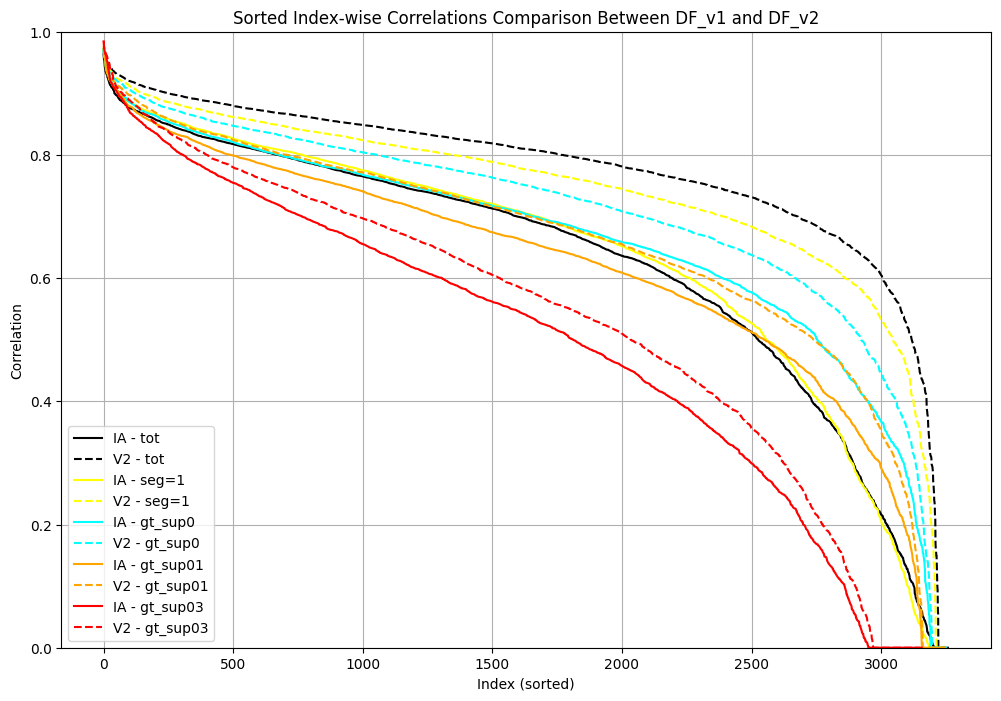

<Figure size 640x480 with 0 Axes>

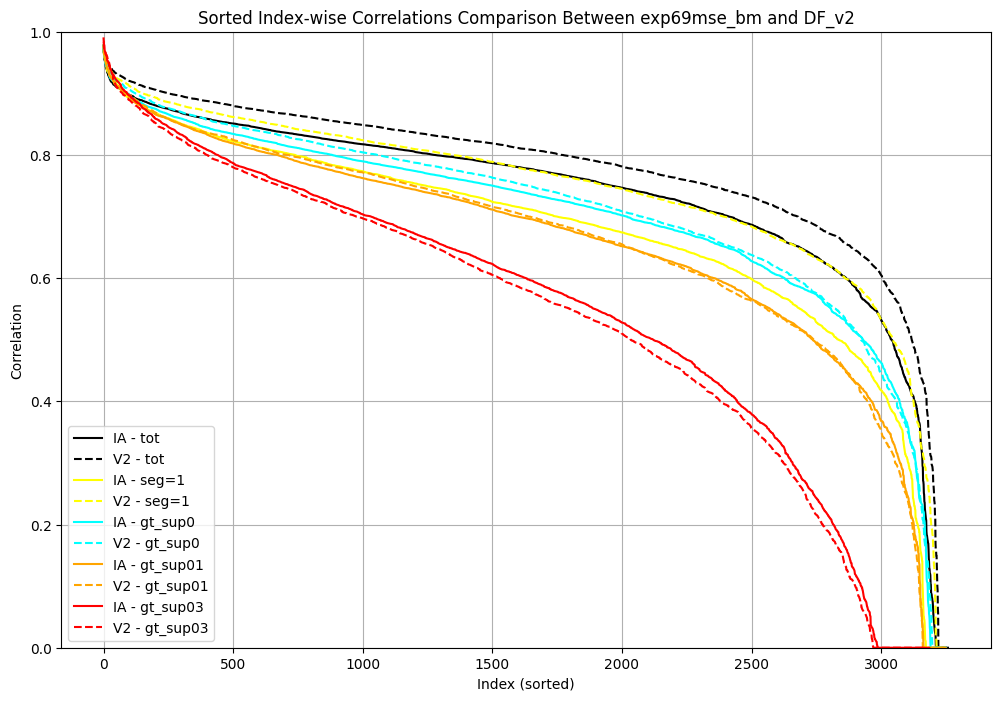

<Figure size 640x480 with 0 Axes>

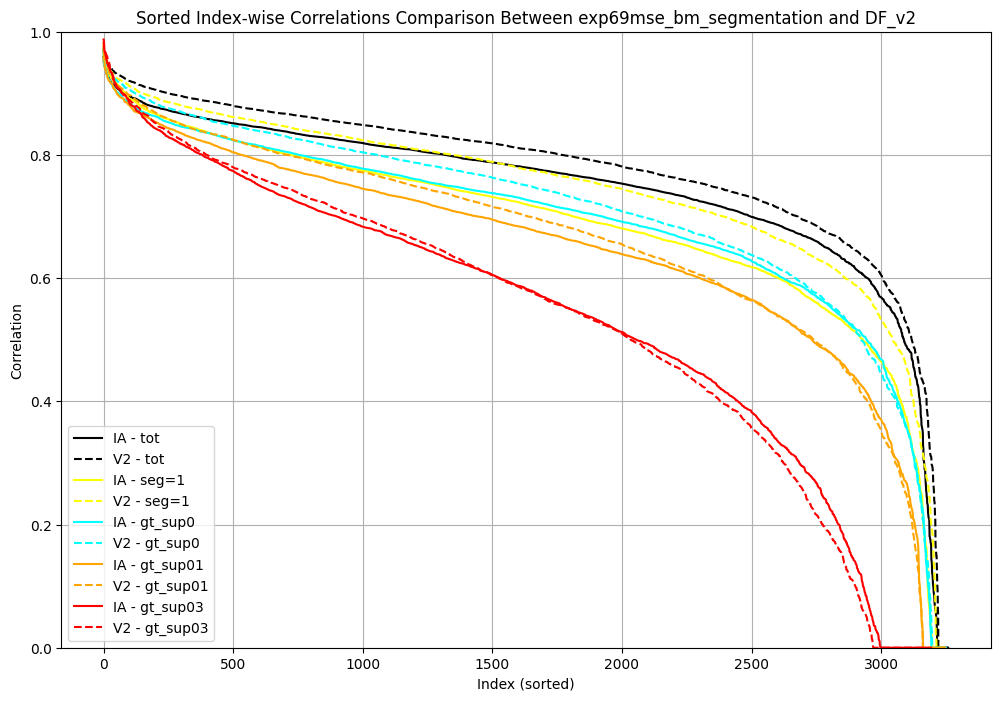

<Figure size 640x480 with 0 Axes>

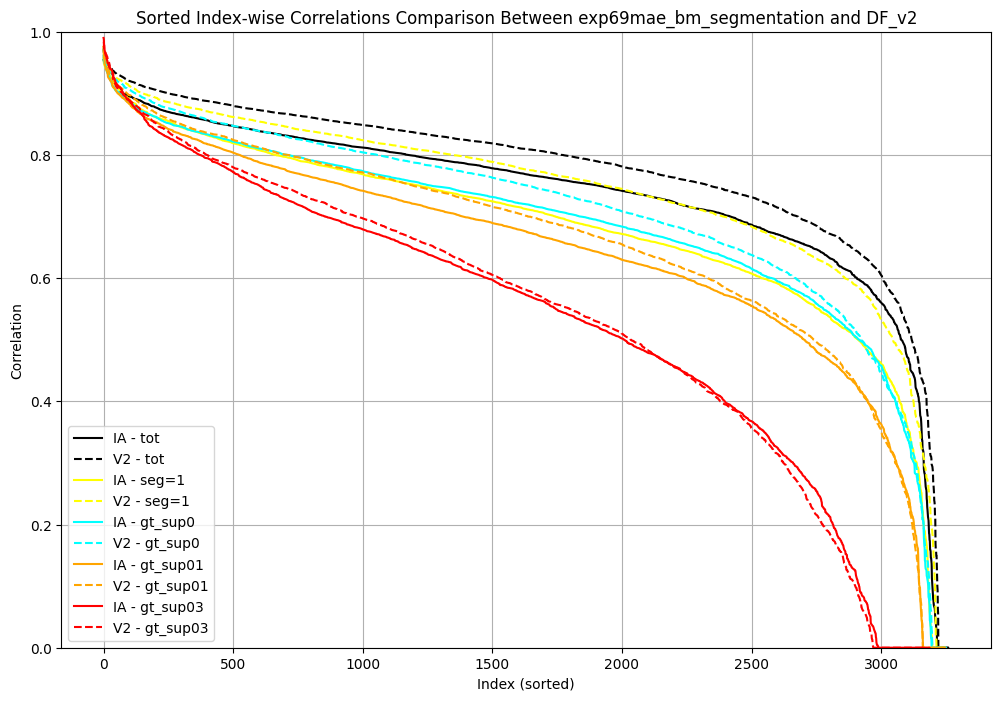

<Figure size 640x480 with 0 Axes>

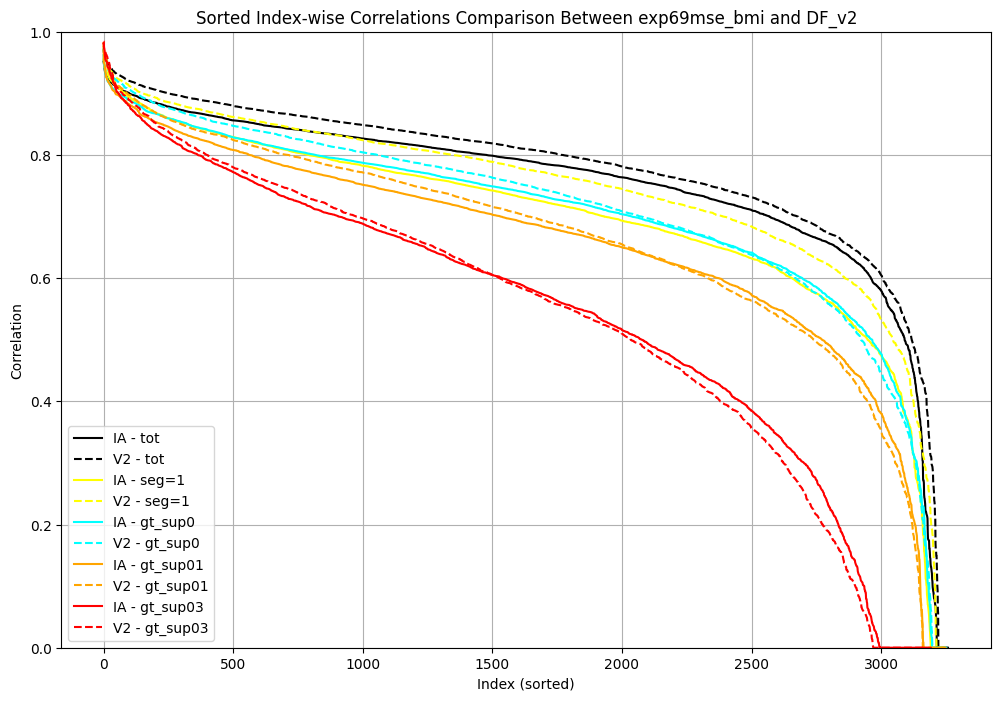

<Figure size 640x480 with 0 Axes>

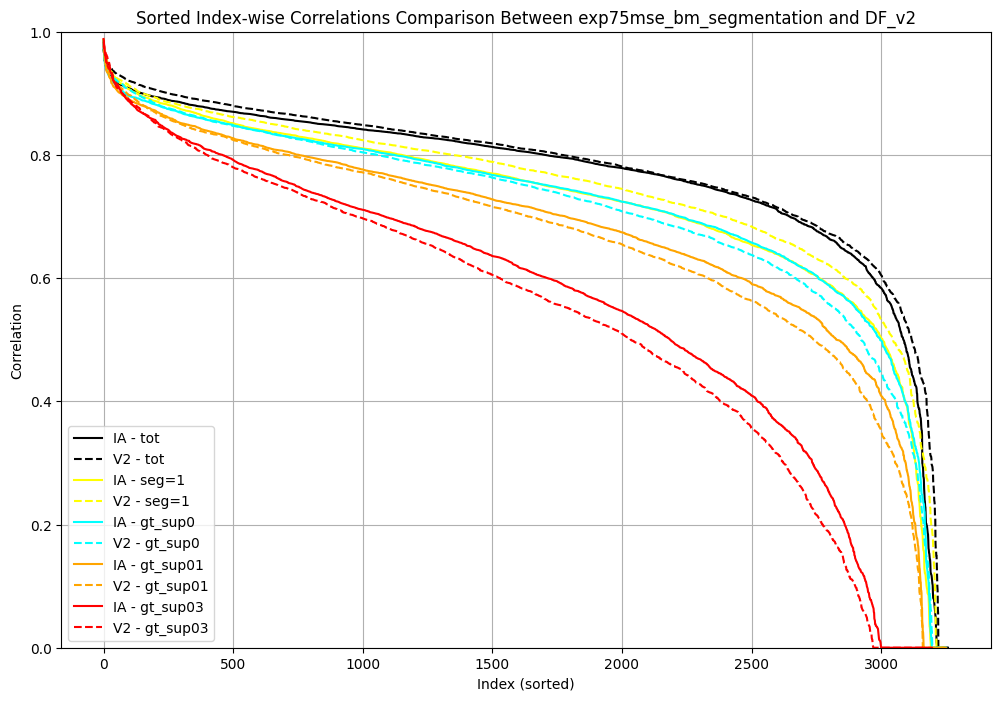

<Figure size 640x480 with 0 Axes>

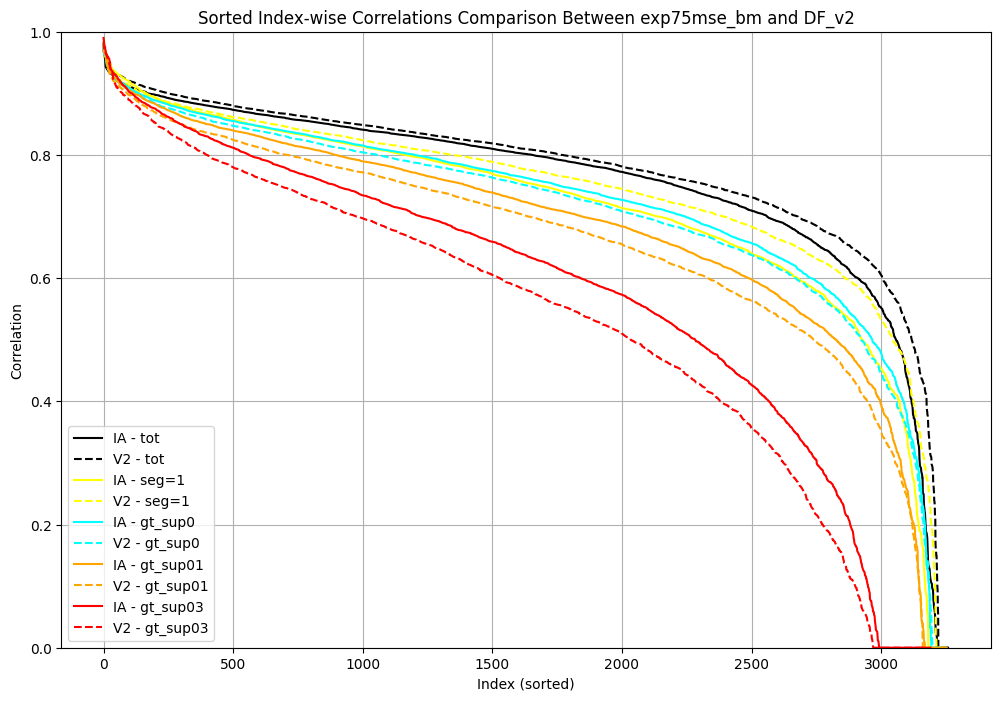

<Figure size 640x480 with 0 Axes>

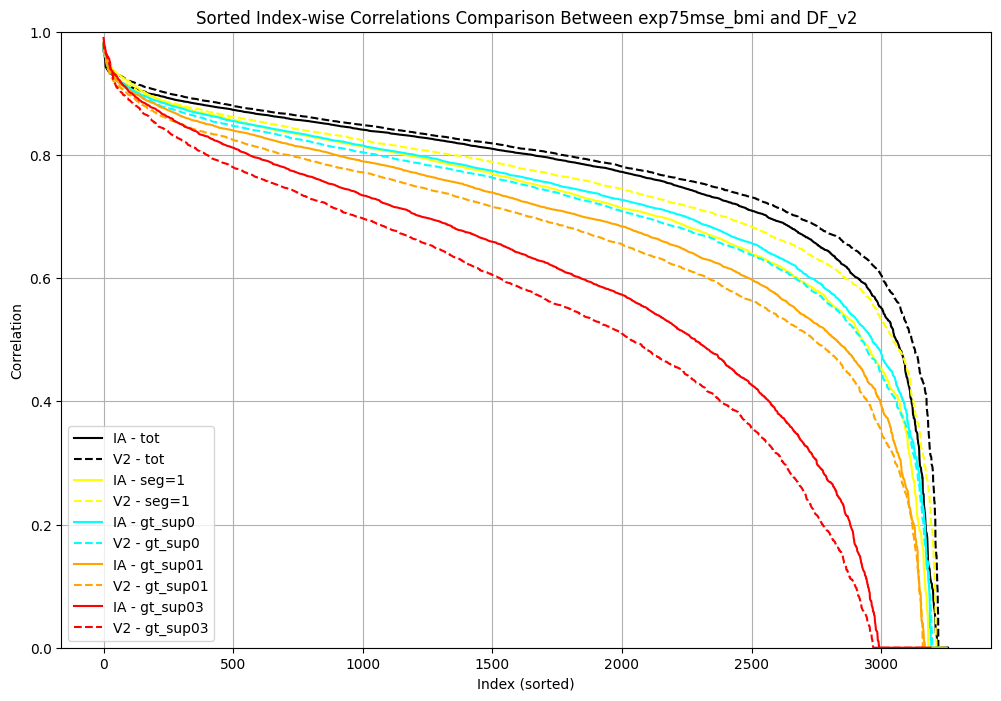

<Figure size 640x480 with 0 Axes>

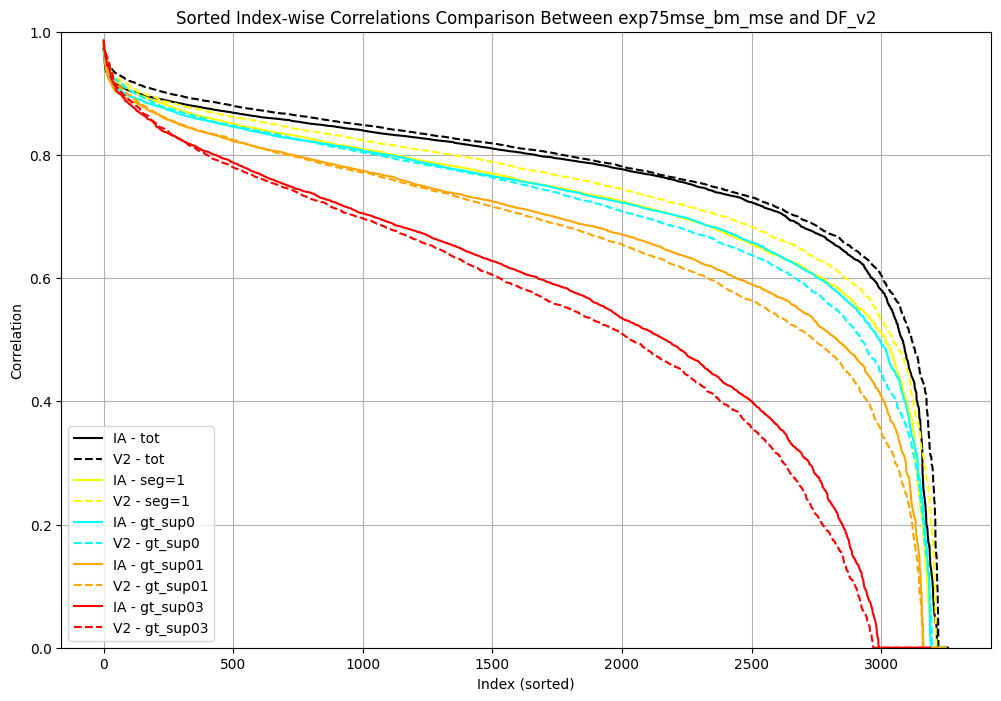

<Figure size 640x480 with 0 Axes>

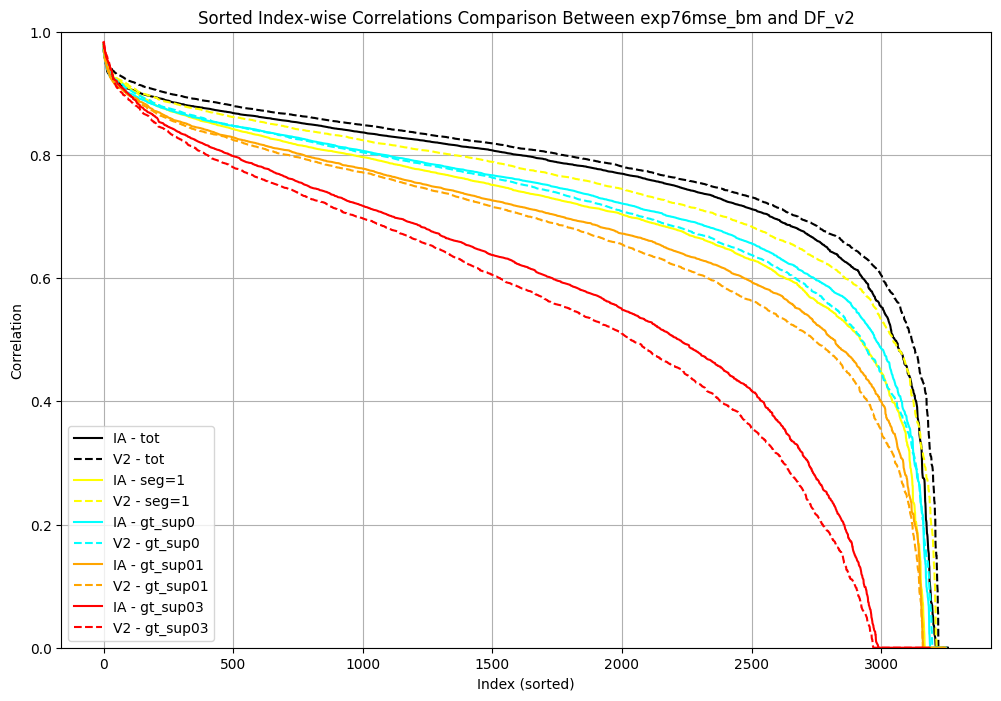

<Figure size 640x480 with 0 Axes>

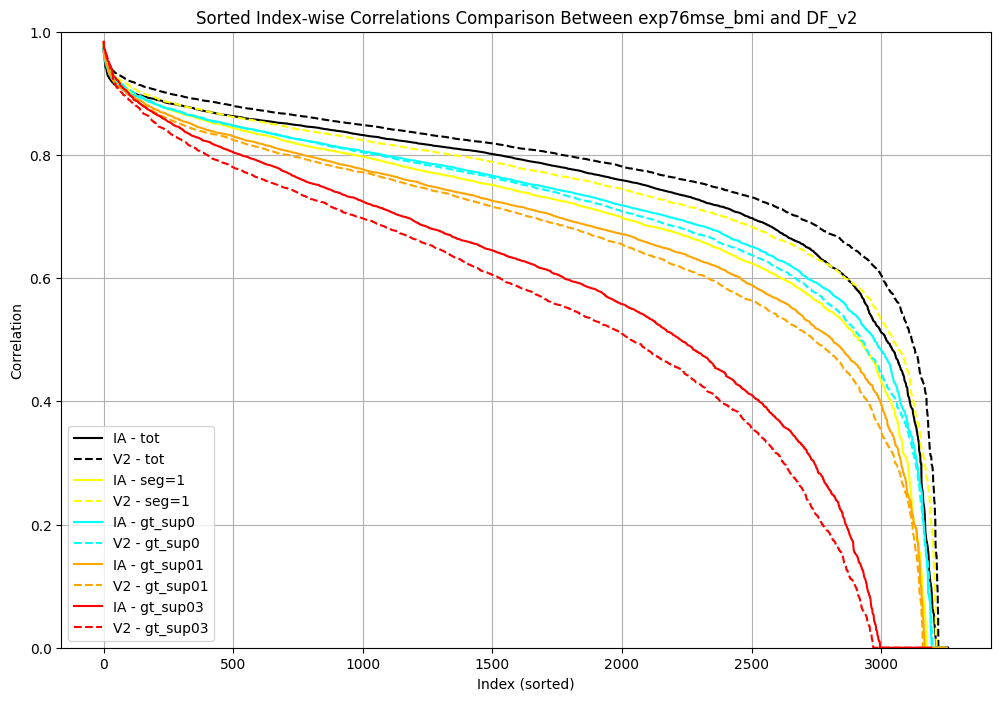

<Figure size 640x480 with 0 Axes>

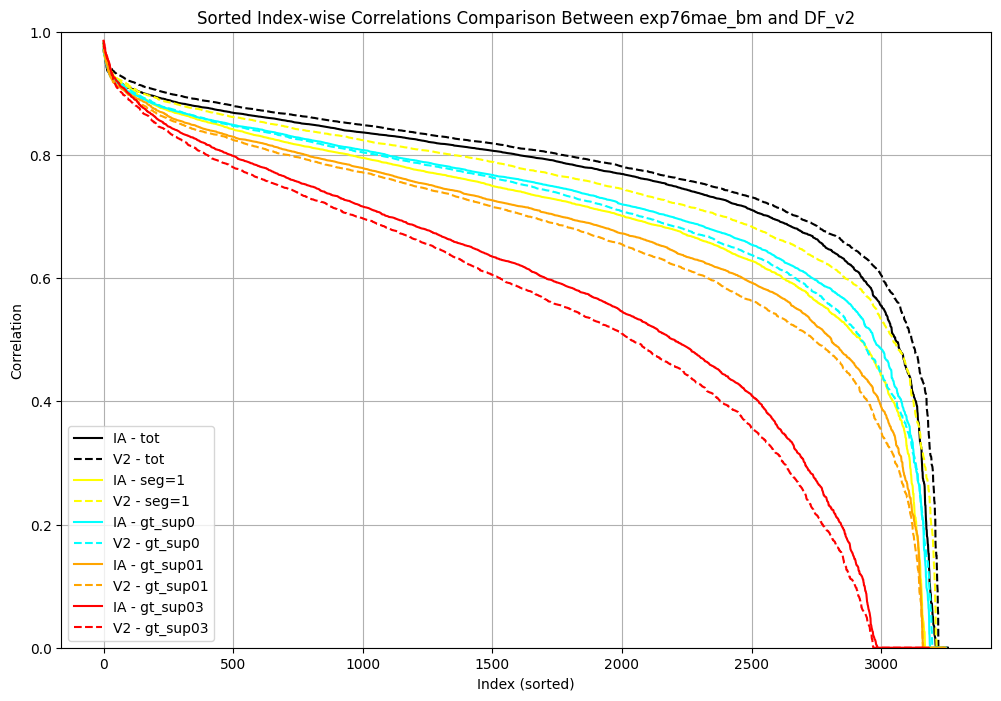

<Figure size 640x480 with 0 Axes>

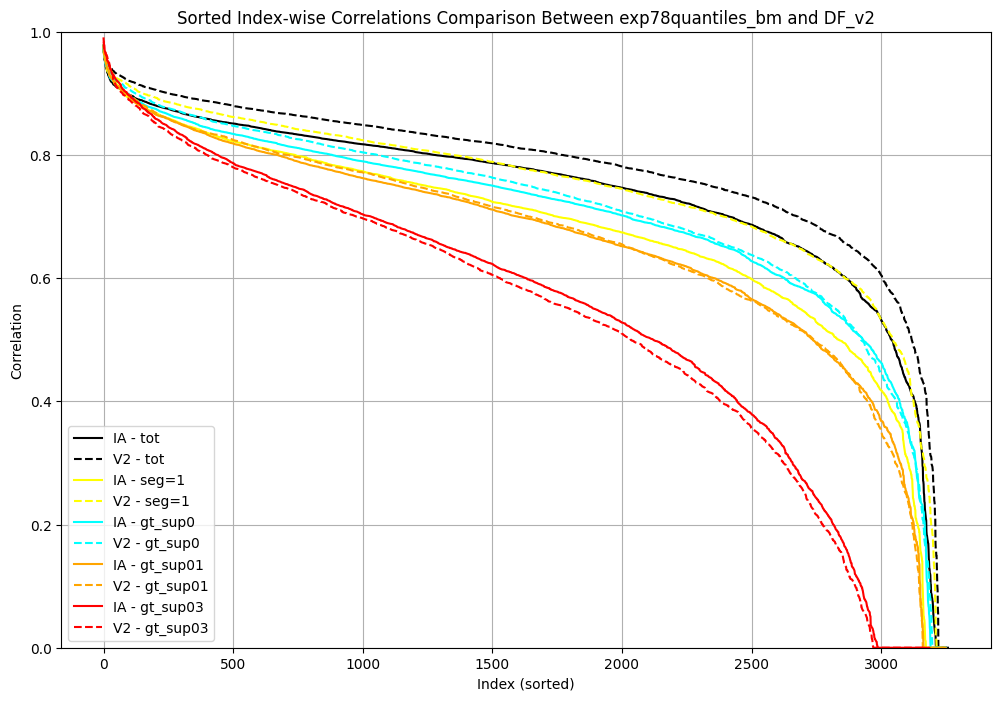

In [230]:
for model_name1 in  ['DF_v1', 'exp69mse_bm',  'exp69mse_bm_segmentation', 'exp69mae_bm_segmentation', 'exp69mse_bmi',
               'exp75mse_bm_segmentation', 'exp75mse_bm', 'exp75mse_bmi', 'exp75mse_bm_mse', 
               'exp76mse_bm', 'exp76mse_bmi', 'exp76mae_bm', 'exp78quantiles_bm']:
    plt.figure()
    model_name2 = 'DF_v2'
    
    dict_scores_model1 = dict_scores[model_name1]  
    dict_scores_model2 = dict_scores[model_name2]  
    
    # Prepare to store the sorted correlations for both models
    sorted_correlations_all_conditions_model1 = {}
    sorted_correlations_all_conditions_model2 = {}
    
    conditions = ['tot','seg=1', 'gt_sup0', 'gt_sup01', 'gt_sup03']
    colors = ['black', 'yellow', 'cyan', 'orange', 'red']
    
    # conditions = ['tot','gt_sup0', 'gt_sup01', 'gt_sup03']
    # colors = ['black',  'cyan', 'orange', 'red']
    
    for condition in conditions:
        # Calculate correlations for model 1
        index_correlations_model1 = calculate_index_correlations(dict_scores_model1, condition)
        sorted_correlations_model1 = sorted(index_correlations_model1.values(), reverse=True)
        sorted_correlations_all_conditions_model1[condition] = sorted_correlations_model1
        
        # Calculate correlations for model 2
        index_correlations_model2 = calculate_index_correlations(dict_scores_model2, condition)
        sorted_correlations_model2 = sorted(index_correlations_model2.values(), reverse=True)
        sorted_correlations_all_conditions_model2[condition] = sorted_correlations_model2
    
    # Step 3: Plot the sorted correlations for each model and condition
    plt.figure(figsize=(12, 8))
    for count, condition in enumerate(conditions):
        plt.plot(sorted_correlations_all_conditions_model1[condition], color=colors[count], linestyle='-',  label=f"IA - {condition}")
        plt.plot(sorted_correlations_all_conditions_model2[condition], color=colors[count], linestyle='--',  label=f"V2 - {condition}")
    
    plt.title("Sorted Index-wise Correlations Comparison Between "  + model_name1  + " and " + model_name2)
    plt.xlabel("Index (sorted)")
    plt.ylabel("Correlation")
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    # ax.set_xlim([xmin, xmax])
    ax.set_ylim([0, 1])
    plt.show()

<Figure size 640x480 with 0 Axes>

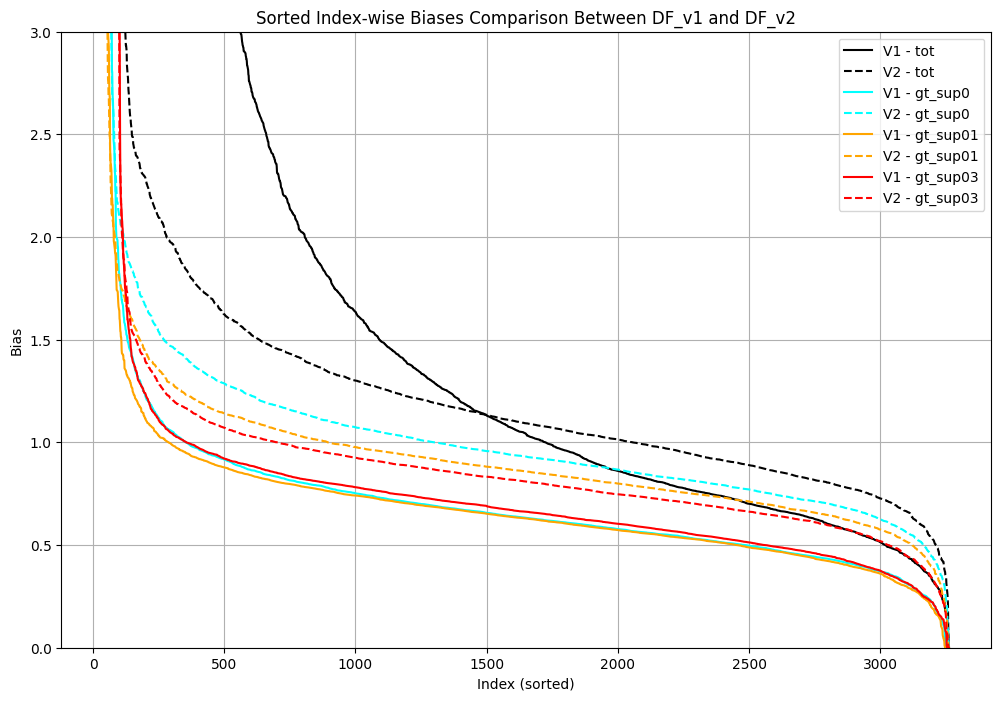

<Figure size 640x480 with 0 Axes>

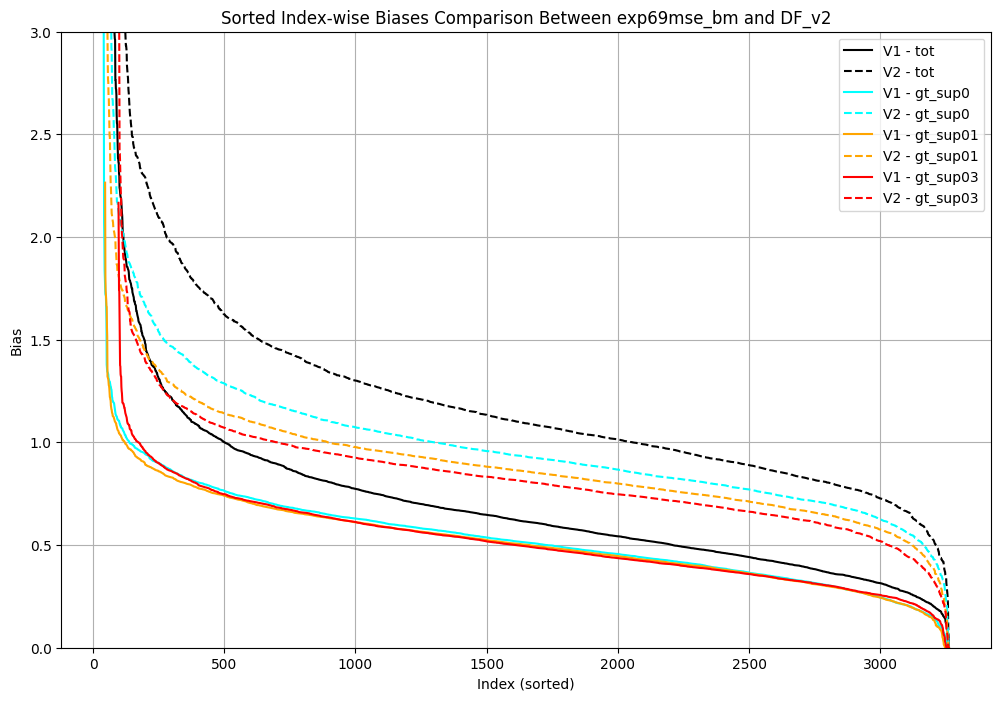

<Figure size 640x480 with 0 Axes>

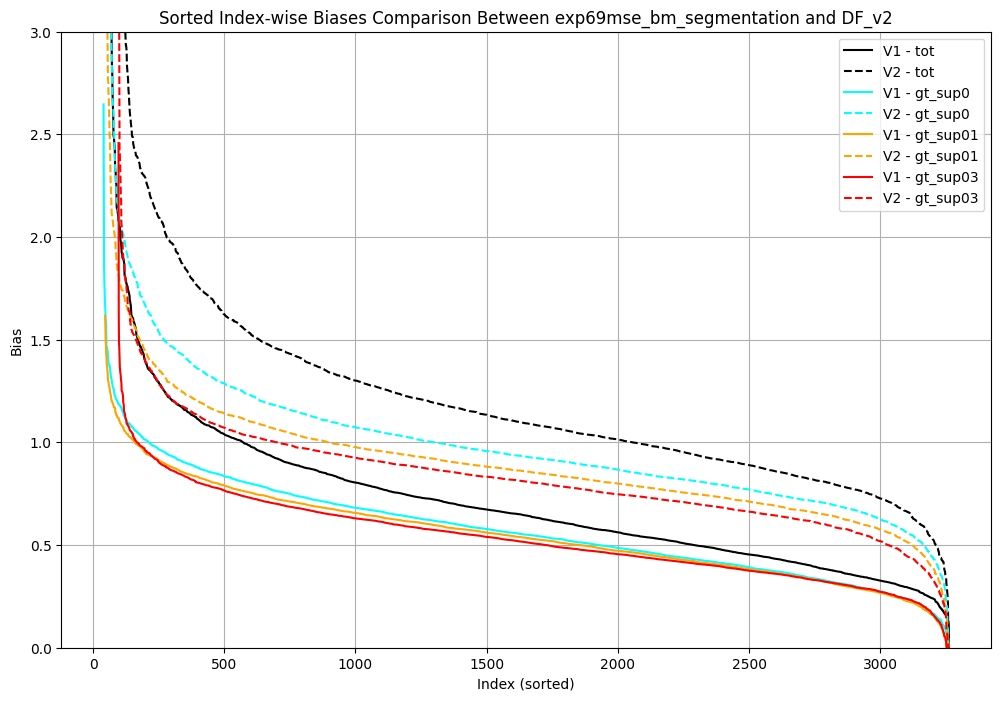

<Figure size 640x480 with 0 Axes>

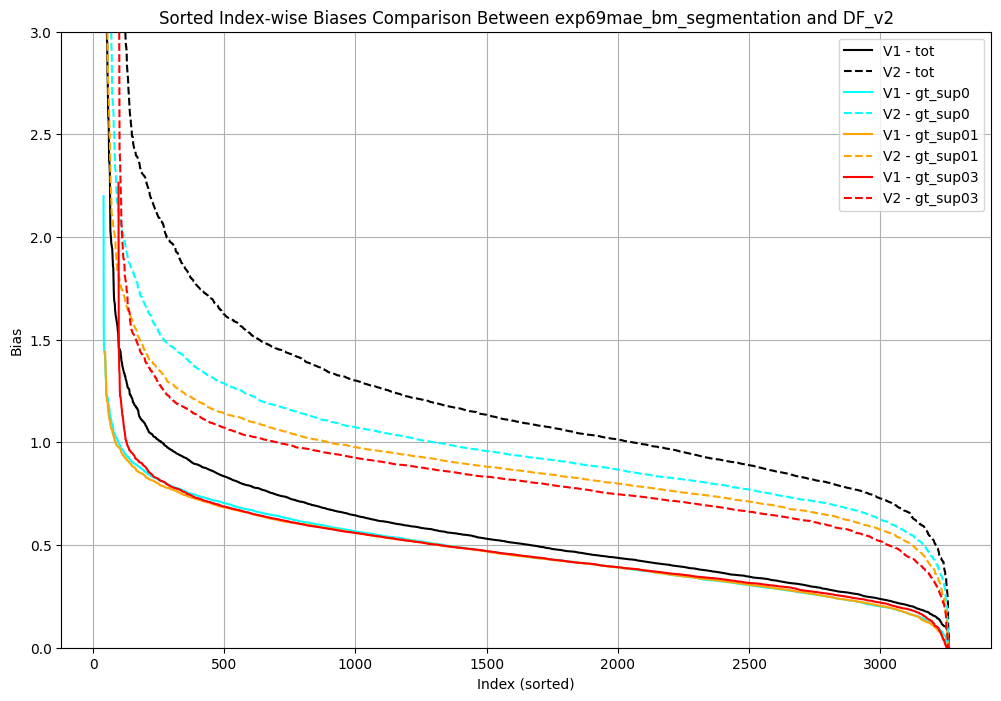

<Figure size 640x480 with 0 Axes>

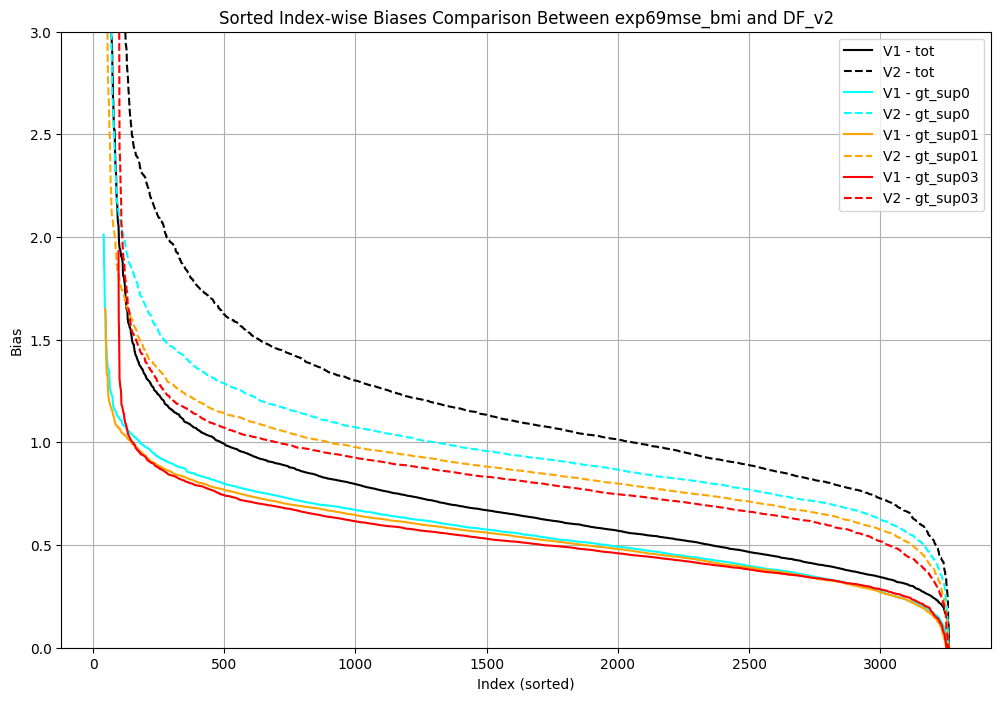

<Figure size 640x480 with 0 Axes>

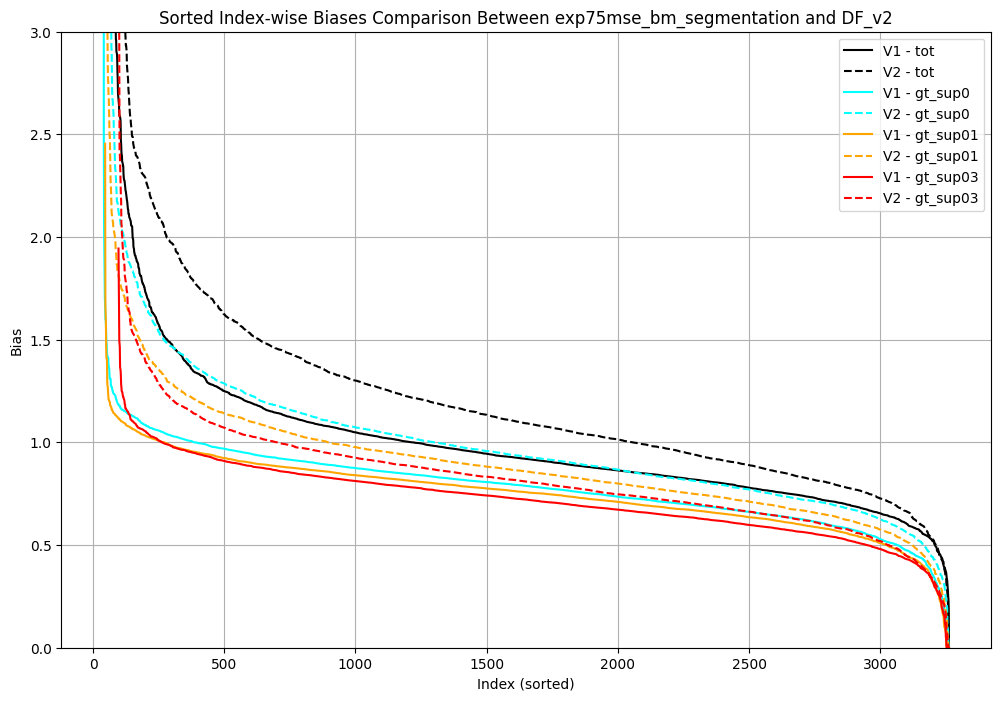

<Figure size 640x480 with 0 Axes>

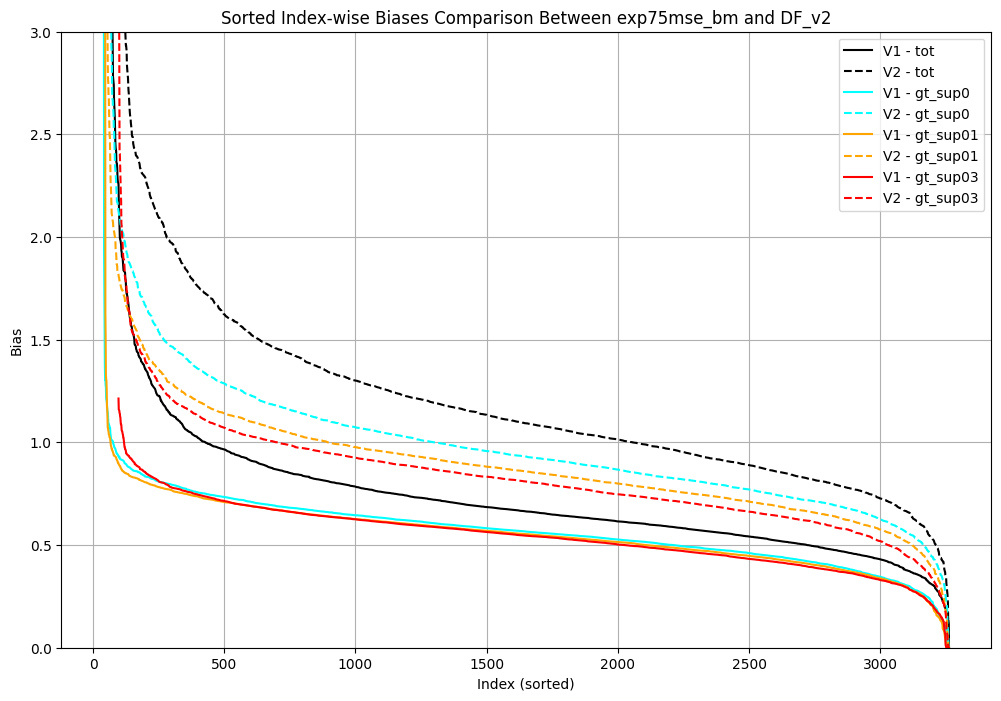

<Figure size 640x480 with 0 Axes>

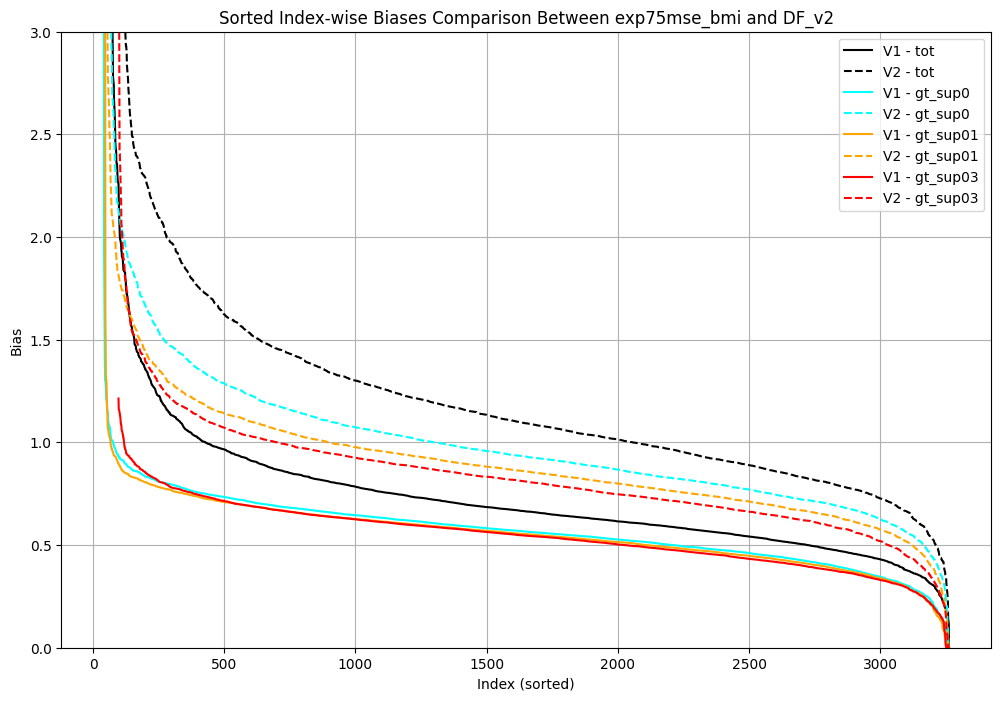

<Figure size 640x480 with 0 Axes>

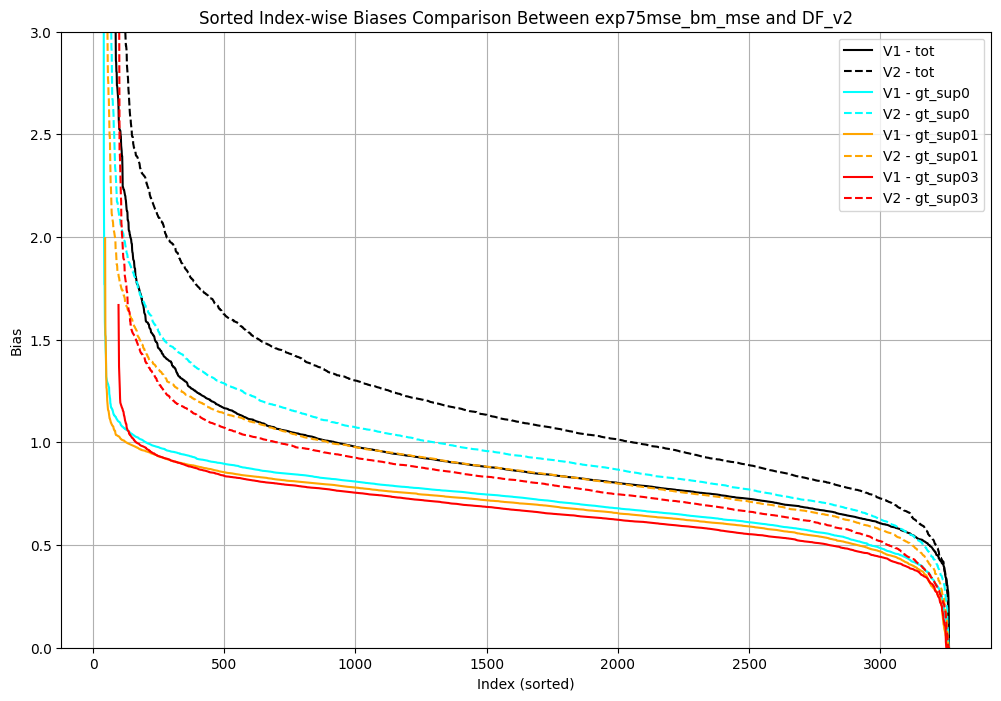

<Figure size 640x480 with 0 Axes>

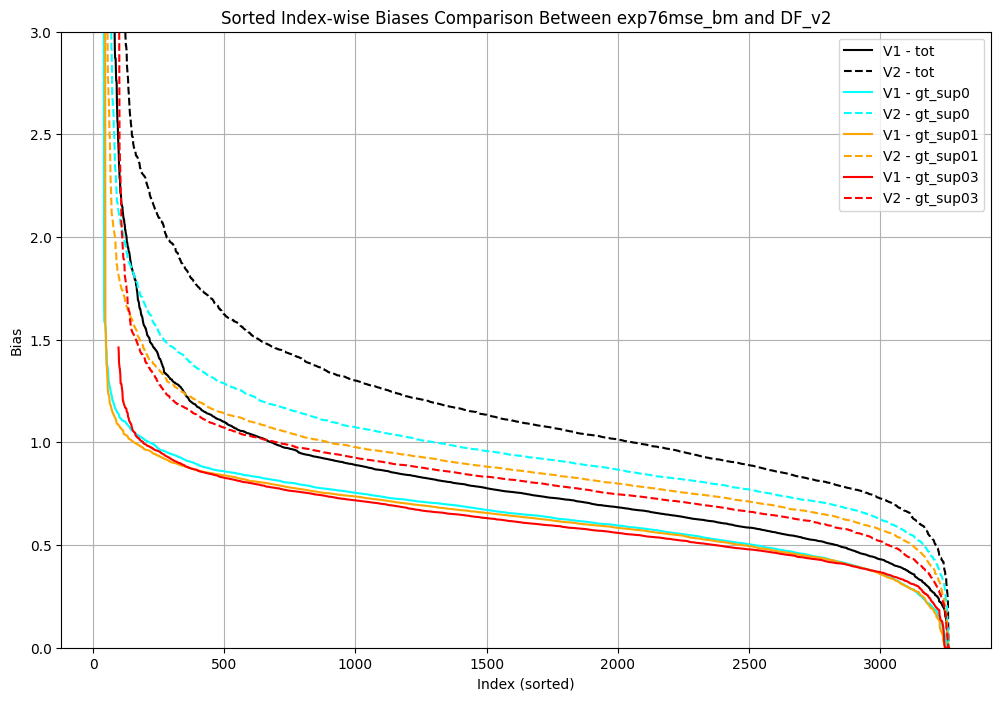

<Figure size 640x480 with 0 Axes>

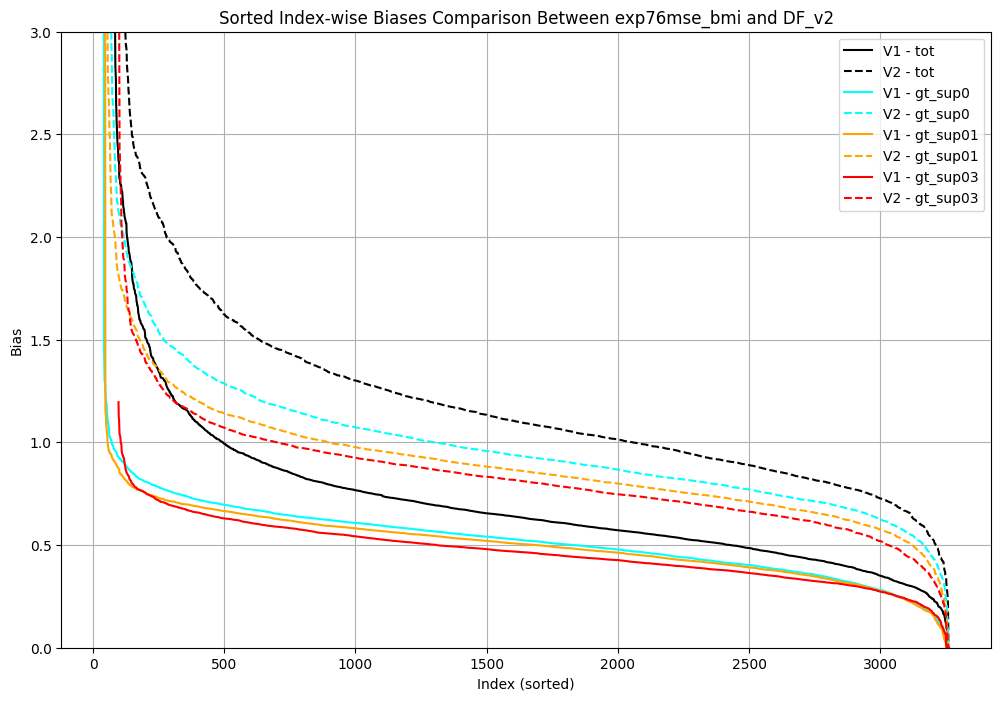

<Figure size 640x480 with 0 Axes>

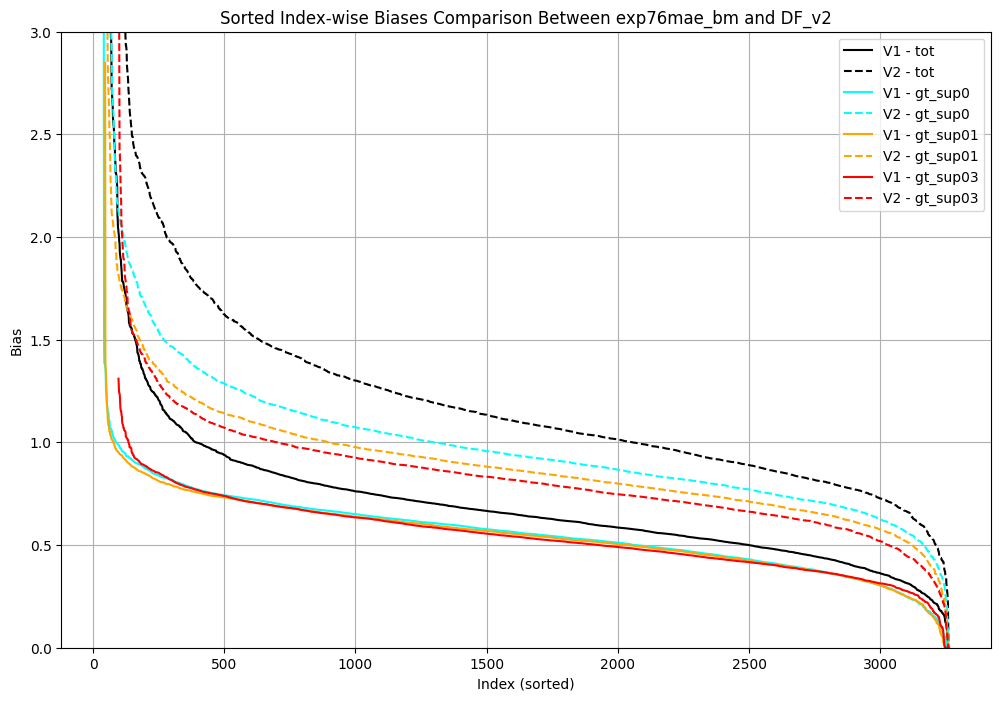

<Figure size 640x480 with 0 Axes>

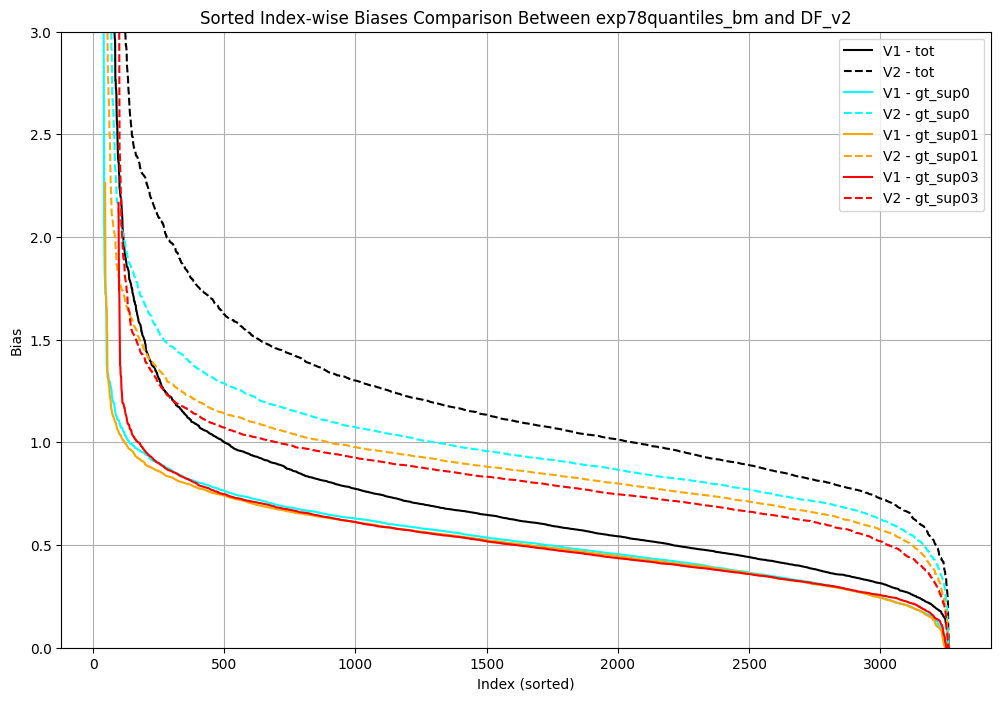

In [233]:
for model_name1 in  ['DF_v1', 'exp69mse_bm',  'exp69mse_bm_segmentation', 'exp69mae_bm_segmentation', 'exp69mse_bmi',
               'exp75mse_bm_segmentation', 'exp75mse_bm', 'exp75mse_bmi', 'exp75mse_bm_mse', 
               'exp76mse_bm', 'exp76mse_bmi', 'exp76mae_bm', 'exp78quantiles_bm']:

    plt.figure()
    model_name2 = 'DF_v2'
    
    dict_scores_model1 = dict_scores[model_name1]  
    dict_scores_model2 = dict_scores[model_name2]  
    
    # Prepare to store the sorted correlations for both models
    sorted_biases_all_conditions_model1 = {}
    sorted_biases_all_conditions_model2 = {}
    
    # conditions = ['tot','seg=1', 'gt_sup0', 'gt_sup01', 'gt_sup03']
    # colors = ['black', 'yellow', 'cyan', 'orange', 'red']
    
    conditions = ['tot','gt_sup0', 'gt_sup01', 'gt_sup03']
    colors = ['black',  'cyan', 'orange', 'red']
    
    for condition in conditions:
        # Calculate correlations for model 1
        index_biases_model1 = calculate_index_biases(dict_scores_model1, condition)
        sorted_biases_model1 = sorted(index_biases_model1.values(), reverse=True)
        sorted_biases_all_conditions_model1[condition] = sorted_biases_model1
        
        # Calculate correlations for model 2
        index_biases_model2 = calculate_index_biases(dict_scores_model2, condition)
        sorted_biases_model2 = sorted(index_biases_model2.values(), reverse=True)
        sorted_biases_all_conditions_model2[condition] = sorted_biases_model2
    
    # Step 3: Plot the sorted correlations for each model and condition
    plt.figure(figsize=(12, 8))
    for count, condition in enumerate(conditions):
        plt.plot(sorted_biases_all_conditions_model1[condition], color=colors[count], linestyle='-',  label=f"ML - {condition}")
        plt.plot(sorted_biases_all_conditions_model2[condition], color=colors[count], linestyle='--',  label=f"V2 - {condition}")
    
    plt.title("Sorted Index-wise Biases Comparison Between "  + model_name1  + " and " + model_name2)
    plt.xlabel("Index (sorted)")
    plt.ylabel("Bias")
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    # ax.set_xlim([xmin, xmax])
    ax.set_ylim([0, 3])
    plt.show()

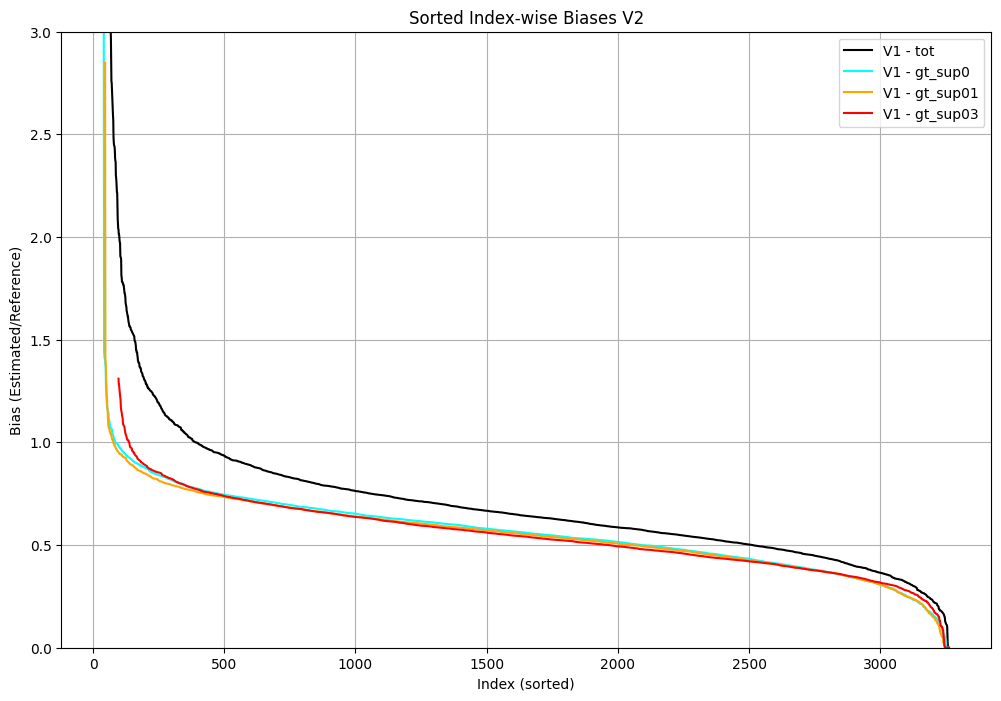

In [118]:

# Replace these with your actual dict_scores for model1 and model2
# dict_scores_model1 = dict_scores['exp69mse_bm_segmentation']  
dict_scores_model1 = dict_scores['exp76mae_bm']  
"""
dict_scores_model2 = dict_scores['DF_v2']
"""
# Prepare to store the sorted biases for both models
sorted_biases_all_conditions_model1 = {}
sorted_biases_all_conditions_model2 = {}

conditions = ['tot', 'gt_sup0', 'gt_sup01', 'gt_sup03']
colors = ['black', 'cyan', 'orange', 'red']

for condition in conditions:
    # Calculate biases for model 1
    index_biases_model1 = calculate_index_biases(dict_scores_model1, condition)
    sorted_biases_model1 = sorted(index_biases_model1.values(), reverse=True)
    sorted_biases_all_conditions_model1[condition] = sorted_biases_model1
    
    # Calculate biases for model 2
    """
    index_biases_model2 = calculate_index_biases(dict_scores_model2, condition)
    sorted_biases_model2 = sorted(index_biases_model2.values(), reverse=True)
    sorted_biases_all_conditions_model2[condition] = sorted_biases_model2
    """
# Plot the sorted biases for each model and condition
plt.figure(figsize=(12, 8))
for count, condition in enumerate(conditions):
    plt.plot(sorted_biases_all_conditions_model1[condition], color=colors[count], linestyle='-',  label=f"V1 - {condition}")
    # plt.plot(sorted_biases_all_conditions_model2[condition], color=colors[count], linestyle='--',  label=f"V2 - {condition}")

plt.title("Sorted Index-wise Biases V2")
plt.xlabel("Index (sorted)")
plt.ylabel("Bias (Estimated/Reference)")
plt.legend()
plt.grid(True)
ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 3])
plt.show()



In [ ]:
# Visualisation (comparaison V1 / V2)
import numpy as np
from datetime import datetime, timedelta
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, DatetimeTickFormatter


def interpolate_targets(input_timestamps, targets, target_time_step_seconds):
    """
    Interpolates target data to match the timestamps of an input time series.
    
    Args:
    input_timestamps (np.array): Array of datetime objects for the input data.
    targets (np.array): Original target data array.
    target_time_step_seconds (int): Time step in seconds between each target data point.
    
    Returns:
    np.array: Interpolated target data array.
    """
    # Calculate the number of points in the original target data
    total_duration_seconds = (input_timestamps[-1] - input_timestamps[0]).total_seconds()
    num_original_points = int(total_duration_seconds // target_time_step_seconds) + 1
    
    # Generate time points for original target data
    original_times = np.array([input_timestamps[0] + timedelta(seconds=i*target_time_step_seconds) for i in range(num_original_points)])
    
    # Convert datetime arrays to floats for interpolation
    original_times_float = np.array([t.timestamp() for t in original_times])
    new_times_float = np.array([t.timestamp() for t in input_timestamps])
    
    # Perform linear interpolation
    interpolated_targets = np.interp(new_times_float, original_times_float, targets)
    
    return interpolated_targets


def generate_datetime_array(length, start_timestamp):
    start_datetime = datetime.strptime(start_timestamp, "%Y%m%d%H%M")
    return np.array([start_datetime + timedelta(seconds=15*i) for i in range(length)])


def plot_time_series_bokeh(time_seriess, labels, colors, start_timestamp, rescale_inputs=1):
    p = figure(width=2000, height=700, title='Sample Time Series from Batch', x_axis_type='datetime',
               x_axis_label='Time (HH:MM)', y_axis_label='Values', y_range=(-0.5, 2))
    
    for i, time_series in enumerate(time_seriess):
        length = len(time_series)
        datetime_array = generate_datetime_array(length, start_timestamp)
        if "5mn" in labels[i]:
            # 5 mn = 20 x 15 secondes
            spacing = 20 // rescale_inputs
            datetime_array = generate_datetime_array((length-1) * spacing + 1, start_timestamp)
            time_series = interpolate_targets(datetime_array, time_series, 300)

            
        source = ColumnDataSource(data={'x': datetime_array, 'y': time_series})
        
        p.line('x', 'y', source=source, legend_label=labels[i], color=colors[i], line_width=2)

    # Formatting the datetime x-axis
    # p.xaxis.formatter = DatetimeTickFormatter(hours="%H:%M", minutes="%H:%M")
    p.xaxis.formatter = DatetimeTickFormatter(
        hours="%d %B %Y %H:%M",
        days="%d %B %Y",
        months="%B %Y",
        years="%Y",
    )

    p.xaxis.major_label_orientation = np.pi/4  # Rotate date labels for better legibility
    p.legend.location = "top_left"
    p.grid.grid_line_alpha = 0.3

    show(p)  # Display the plot

In [ ]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()  # Renders the plot inline in a Jupyter notebook

In [ ]:
path_md = '/scratch/mdso/lepetitp/ppc/RAINCELL/METADATA/metadata.csv' # index=False, sep=';',
mds = pd.read_csv(path_md, sep=';')
print(mds.columns)

In [ ]:
# Plot
dir_database = '/scratch/mdso/lepetitp/ppc/RAINCELL/datasets/database_debiasing'
# Use weights for sampling
import torch.nn.functional as F
from ia.learning.dependencies.utile_visualisation import plot_time_series_bokeh
model.eval()  # Set the model to evaluation mode
validation_type = "test_intra"
num_series_to_plot = 50

exp = 'exp78quantiles_bm'
if exp == 'exp78quantiles_bm':
    """
    python learning/preprocessing/train_1GPU_MAE_PNP.py lastepo UNet_causal_5mn_atrous_rescale
    -lr 0.001 -bs 128 -ne 100 -pr 20240815_exp76_maskedMSE_maskedMAE  -ss 30  -lrc -miv -10
    -comp -mcl CE_maskedMSE_maskedMAE -ste 110000 -sm 100 -lor  -dbs -dbci
    """
    completion = True
    min_input_value = -10 
    rescale_inputs = None
    rescale_targets = "nan_padding"
    archi = "UNet_causal_5mn_atrous"
    size_model = 100
    long_receptive_field = True
    additional_parameters = 16
    mode_complete_loss = 'CE_maskedMSE_maskedQ'
    quantiles = 4
    learned_outputs_rescaling = False
    input_lengths = False
    fixed_cumul = False
    model_name = '20240817_exp78_CE_maskedMSE_maskedQ_UNet_causal_5mn_atrous_lr1step_size30_gamma300_crop_size12720_crop_step1_bm.checkpoint'
    PATH_weights = join(dir_models, model_name)
    mode = 'quantiles'
    
# load the model:
nchannels = 2
if input_lengths:
    nchannels = 2
nclasses = 3
if mode_complete_loss in ['CE_MSE_MAE', 'CE_maskedMSE_maskedMAE']:
    nclasses = 4 # 2 segmentation, 1 MSE, 1 MAE
if mode_complete_loss in ['CE_MSE_Q', 'CE_maskedMSE_maskedQ']:
    nclasses = 3 + quantiles - 1  
if mode_complete_loss in ['CE_MSE_MSE1h', 'CE_MSE_MSEsum5min']:
    nclasses = 3 + 1

if long_receptive_field :
    dilation=2
    atrous_rates=[6, 12, 18, 24, 30, 36, 42]
    model = load_archi(archi, nchannels, nclasses, size=size_model, dilation=dilation, atrous_rates=atrous_rates, 
                       fixed_cumul=fixed_cumul, additional_parameters=additional_parameters)

else:
    model = load_archi(archi, nchannels, nclasses, size=size_model, atrous_rates=[6, 12, 18],
                       fixed_cumul=fixed_cumul, additional_parameters=additional_parameters)

model = model.to(device)

# load the checkpoint:
checkpoint = torch.load(PATH_weights, \
                        map_location=device)
last_epoch = checkpoint['epoch']
print(exp + ' from epoch :' , last_epoch) 

model_weights = checkpoint['model']
model.load_state_dict(model_weights)
model.eval()



for j, (len_stubs, linkids, months, inputs, targets) in enumerate(dataloader):
    if j ==1:
        print(j)
        break

        
#get DF_v1
with torch.no_grad():
    #get DF_v1
    DF_v1 = inputs[:,3, margin:].to(device)
    mask_DF_v1 = DF_v1 >= 0

    # agregate DF to get 5 mn waterfall
    DF_v1[DF_v1<0] = 0
    DF_v1 = trailing_moving_average(DF_v1.unsqueeze(1), window_size=20).squeeze(1)
    DF_v1 /= 12

    # get PNP_DF_V1
    PNP_DF_v1 = inputs[:,2, margin:].to(device) 
    # Combine both masks : there are PNP < 0 with QPE >=0 and vice versa
    mask_DF_v1 *= PNP_DF_v1 >= 0 
    # makes a boolean array
    PNP_DF_v1 = PNP_DF_v1 > 0
    
    # get DF_V2
    DF_v2 = targets[:,1, margin:].to(device)
    PNP_DF_v2 = (DF_v2 > 0)

    #get ground truth
    antilope_5mn = targets[:,0, margin:].to(device)
    PNP_antilope_5mn = (antilope_5mn > 0)
    category_hydre = targets[:,2, margin:].to(device) 
    # quality = targets[:,3, margin:].to(device)         
    


    # Get outputs
    if learned_outputs_rescaling:
        outputs = model(inputs[:, :2, 1:].to(device), indices=linkids.to(device))
        outputs, p = outputs
        outputs[:,2:,:] *= p[5:].view(outputs.shape[0],1,1) 
    else:
        outputs = model(inputs[:, :2, 1:].to(device))
        

    # Compensate the first time step removal and apply the 12 h margin:
    zeros_to_add = torch.zeros(outputs.size(0), outputs.size(1), 1, device=outputs.device)
    outputs = torch.cat([zeros_to_add, outputs], dim=2)
    outputs = outputs[:,:, margin:]
    
    # Get the preds:
    PNP_IA = outputs[:,1,:] > outputs[:,0,:]

    if mode == 'mse':
        QPE_IA = outputs[:,2,:]
    elif mode == 'mae':
        QPE_IA = outputs[:,3,:]
    elif mode == 'quantiles' and quantiles == 4:
        QPE_IA = outputs[:,4,:]

    # MAsking 
    QPE_IA *= PNP_IA

    for i in range(6):
        # if i not in [6, 7, 8]:
        #     continue
        idx = linkids[i].item()
        timestamp =  sorted(ls(join(dir_database, str(idx), months[i])) 
        time_series_A = inputs[i,0].cpu().numpy()
        time_series_B = inputs[i,1].cpu().numpy()
        time_series_DF = inputs[i,3].cpu().numpy()
        time_series_DF /= 12
        time_series_DF[time_series_DF<0] = -0.1
        time_series_PNP = inputs[i,2].cpu().numpy()
        time_series_PNP[time_series_PNP<0] = -0.1
        time_series_targets = targets[i,0].cpu().numpy()
        print((time_series_targets).shape)
        print(time_series_targets[time_series_targets<-10])
        time_series_cvprecip = targets[i,1].cpu().numpy()
        time_series_quality = targets[i,2].cpu().numpy()
        time_series_hydre = targets[i,3].cpu().numpy()
        time_series_outputs = np.insert(outputs[i,0].numpy(), 0, 0) 
        time_series_outputs2 = np.insert(outputs[i,2].numpy(), 0, 0) 
        time_series_outputs[time_series_outputs<0] = 0
        
        time_series_targets = time_series_targets[(time_series_targets >= -1)]
        weight = weights[i]
        raincell_id = dict_indices[idx]['id']
        # Plot inputs / outputs / targets
        # print(i, idx, timestamp, raincell_id)
        # plot_time_series_bokeh(time_seriess, labels, colors, timestamp)

        # Plot inputs / targets
        # time_seriess = [time_series_A, time_series_B, time_series_targets]
        # labels = ['series_A', 'series_B', 'antilope 5mn']
        # colors = ['orange','red', 'green']

        # Plot inputs / outputs / targets
        # time_seriess = [time_series_A, time_series_B, time_series_targets,time_series_outputs]
        # labels = ['series_A', 'series_B', 'antilope 5mn', 'ouput']
        # colors = ['orange','red', 'green','blue']
        # plot_time_series_bokeh(time_seriess, labels, colors, timestamp)

        # Plot outputs / targets / outputs_DF, PNP
        print(i, timestamp, time_series_DF.shape,time_series_targets.shape, time_series_outputs.shape, weight.item())
        time_seriess = [time_series_DF, time_series_PNP, time_series_targets,time_series_outputs]
        labels = ['estimation D.Faure', 'PNP D.Faure', 'antilope 5mn', 'ouput']
        colors = ['violet','red', 'green','blue']
        plot_time_series_bokeh(time_seriess, labels, colors, timestamp)


        # Plot inputs (A) / outputs / targets / hydre
        # condition = (mds['stations_id'] == raincell_id[0]) & (mds['link_id'] == raincell_id[1])
        # filtered_mds = mds[condition]
        # print(filtered_mds[['latitude_a', 'longitude_a', 'altitude_a','latitude_b', 'longitude_b', 'altitude_b', 'longueur']])
        # fillh = time_series_hydre[0]
        # for k,h in enumerate(time_series_hydre):
        #     if h < 0:
        #         time_series_hydre[k] = fillh
        #     else:
        #         fillh = h
        # time_seriess = [time_series_A,time_series_B, time_series_targets, time_series_outputs, time_series_hydre/5]
        # labels = ['series_A', 'series_B', 'antilope 5mn', 'ouput', 'hydre']
        # colors = ['orange', 'yellow', 'green','blue', 'red']
        # plot_time_series_bokeh(time_seriess, labels, colors, timestamp)


        # Cas d'un modèle entraîné en multitâche :
        # condition = (mds['stations_id'] == raincell_id[0]) & (mds['link_id'] == raincell_id[1])
        # filtered_mds = mds[condition]
        # print(filtered_mds[['latitude_a', 'longitude_a', 'altitude_a','latitude_b', 'longitude_b', 'altitude_b', 'longueur']])
        # fillh = time_series_hydre[0]
        # for k,h in enumerate(time_series_hydre):
        #     if h < 0:
        #         time_series_hydre[k] = fillh
        #     else:
        #         fillh = h
        # time_seriess = [time_series_A, time_series_targets, time_series_outputs, time_series_outputs2, time_series_hydre/5]
        # labels = ['series_A', 'antilope 5mn', 'output', 'time_series_outputs2', 'hydre']
        # colors = ['orange',  'green','blue', 'yellow','red']
        # plot_time_series_bokeh(time_seriess, labels, colors, timestamp)

        

